# Milestone 2

## Bab 1 Perkenalan

### 1.1 Identitas

Nama : Muhamad Bagus Septian

Batch : FTDS-013

### 1.2 Dataset

Dataset yang digunakan pada penelitian ini merupakan dataset tentang gambar pemakaian masker seseorang. Dataset tersebut diakses dari kaggle dengan tautan https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset


### 1.3 Problem

Dewasa ini masih banyak ditemukan kasus inferksi virus covid 19. Padahal wabah tersebut sudah berlangsung selama beberapa tahun dan sudah ada panduan pencegahan penyebaran virus covid seperti pemakaian masker. Memakai masker terbukti menurunkan resiko infeksi covid sebesar 70%. Meskipun demikian masih banyak orang yang berpergian keluar rumah tanpa masker. Di tempat umum, mengerahkan petugas keamanan untuk mengontrol orang-orang agar memakai masker pun dilakukan sebagai salah satu bentuk pencegahan wabah. Akan tetapi keterbatasan para petugas keamanan untuk mengawasi pengunjung tempat umum yang jumlahnya lebih banyak dari mereka membuat kontrol tersebut sulit dilakukan. Oleh karena itu diperlukan suatu sistem yang dapat mengawasi pemakaian masker seseorang di tempat umum.

### 1.4 Objective

Memprediksi pemakaian masker melalui gambar.

## Bab 2 Import Libraries

In [2]:
import os 
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Recall
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
import pickle

## Bab 3 Data Loading

### 3.1 Retrieving Data From Kaggle

In [2]:
# Membuat directory `.kaggle` 
!mkdir ~/.kaggle

# Copy kaggle.json ke directory 
!cp kaggle.json ~/.kaggle/

# Mengubah perizinan untuk directory : 
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Mendownload dataset dari kaggle
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

 94% 312M/330M [00:01<00:00, 218MB/s]
100% 330M/330M [00:01<00:00, 209MB/s]


In [4]:
# Unzip dataset yang sudah didownload
!unzip -q /content/face-mask-12k-images-dataset.zip -d images

### 3.2 Creating Dataframe

In [3]:
# Mengecek list directory data
os.listdir('/content/images/Face Mask Dataset')

['Test', 'Train', 'Validation']

In [4]:
# Mendefinisikan directory data
main_path= '/content/images/Face Mask Dataset'

In [5]:
# Membagi directory ke train, validation dan test
train_dir = os.path.join(main_path, 'Train')
val_dir = os.path.join(main_path, 'Validation')
test_dir = os.path.join(main_path, 'Test')

In [6]:
# Membagi directory sesuai labelnya
train_withmask = glob.glob(train_dir+"/WithMask/*.png")
train_withoutmask = glob.glob(train_dir+"/WithoutMask/*.png")

val_withmask = glob.glob(val_dir+"/WithMask/*.png")
val_withoutmask = glob.glob(val_dir+"/WithoutMask/*.png")

test_withmask = glob.glob(test_dir+"/WithMask/*.png")
test_withoutmask = glob.glob(test_dir+"/WithoutMask/*.png")

In [7]:
# Mendefinisikan fungsi untuk mengubah list directory data ke dataframe
def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
       data.append((image, image.split('/')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

In [8]:
# Mengubah list directory ke dataframe
train_df = create_dataframe(train_withmask + train_withoutmask)
train_df = train_df.sample(frac=1, random_state=1).reset_index(drop=True)

val_df = create_dataframe(val_withmask + val_withoutmask)
val_df = val_df.sample(frac=1, random_state=1).reset_index(drop=True)

test_df = create_dataframe(test_withmask + test_withoutmask)
test_df = test_df.sample(frac=1, random_state=1).reset_index(drop=True)

### 3.3 Data Overview

In [9]:
train_df.head()

images        label
0  /content/images/Face Mask Dataset/Train/Withou...  WithoutMask
1  /content/images/Face Mask Dataset/Train/WithMa...     WithMask
2  /content/images/Face Mask Dataset/Train/WithMa...     WithMask
3  /content/images/Face Mask Dataset/Train/WithMa...     WithMask
4  /content/images/Face Mask Dataset/Train/Withou...  WithoutMask

In [10]:
train_df.tail()

images        label
9995  /content/images/Face Mask Dataset/Train/WithMa...     WithMask
9996  /content/images/Face Mask Dataset/Train/Withou...  WithoutMask
9997  /content/images/Face Mask Dataset/Train/WithMa...     WithMask
9998  /content/images/Face Mask Dataset/Train/Withou...  WithoutMask
9999  /content/images/Face Mask Dataset/Train/WithMa...     WithMask

Diketahui pada dataset train terdapat 10000 gambar

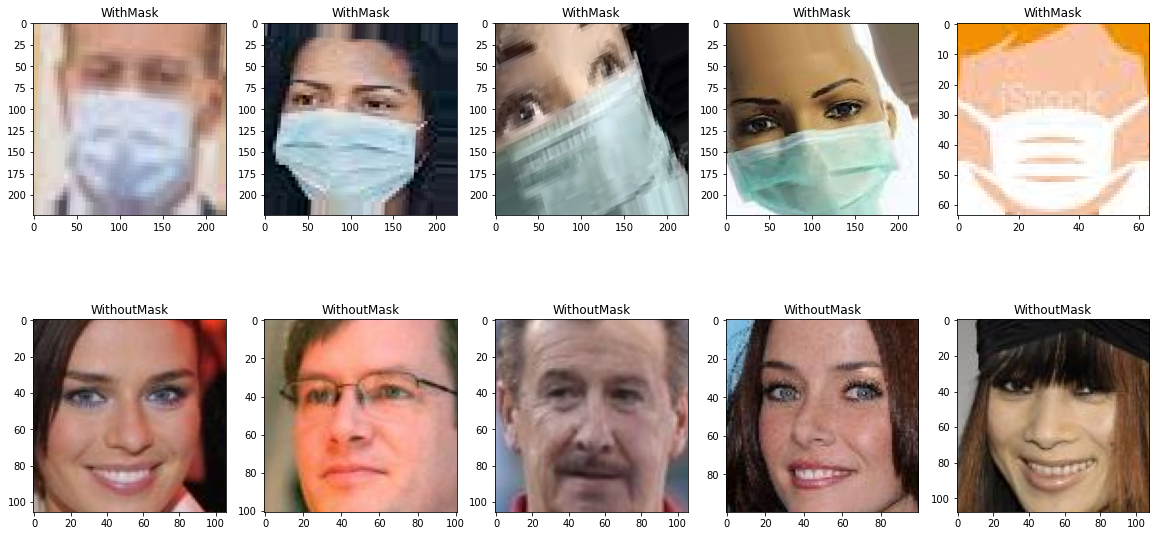

In [11]:
# Mengambil beberapa sampel untuk preview data
withmask_preview = (train_df[train_df['label']=="WithMask"]['images'].iloc[:5]).tolist()
withoutmask_preview = (train_df[train_df['label']=='WithoutMask']['images'].iloc[:5]).tolist()

# Memvisualisasikan sampel gambar
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('/')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_samples(withmask_preview + withoutmask_preview)

Dari visualisasi diatas dapat terlihat bahwa gambar dalam dataset adalah gambar wajah manusia dengan memakai masker untuk gambar pada kelas WithMask dan tidak memakai maske untuk kelas WitoutMask.

## Bab 4 Exploratory Data Analysis

### 4.1 Class Proportion

Sebelum melakukan explorasi data, peneliti akan mendefinisikan fungsi untuk melakukan perhitungan proporsi tiap kelas pada dataset.

In [12]:
# Mendefinisikan fungsi untuk melihat proporsi kelas
def proportion_data(dataframe, label):
    fig, ax = plt.subplots(figsize =(8, 5))
    ax = sns.countplot(x='label', data=dataframe, palette='Spectral')
    ax.set_title('Data Distribution')
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')
    
    plt.xlabel("Label", size=14)
    plt.ylabel("Jumlah", size=14)
    plt.title(f"{label} Distribution", size=10)
    plt.show()

Peneliti ingin melhat proporsi kelas pada train dataset.

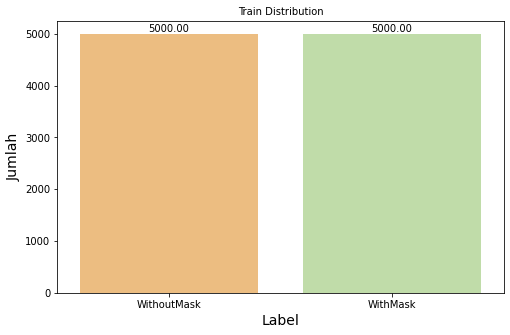

In [13]:
proportion_data(train_df, 'Train')

Diketahui terdapat proprosi kelas yang seimbang pada dataset train yaitu 5000 WithMask dan 5000 WithoutMask

Peneliti ingin melihat proporsi kelas pada validation dataset.

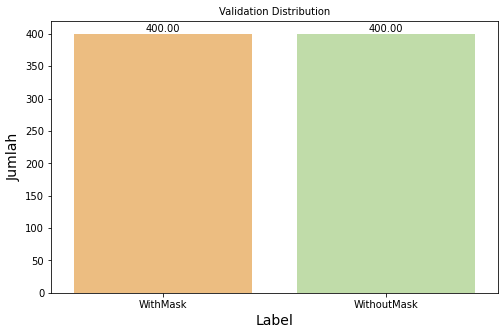

In [14]:
proportion_data(val_df, 'Validation')

Diketahui pada validation dataset juga ditemukan proporsi kelas yang seimbang yaitu 400 WithMask dan 400 WithoutMask.

Peneliti ingin mengetahui proporsi kelas pada test dataset.

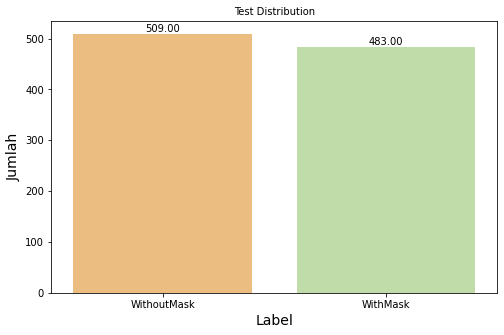

In [15]:
proportion_data(test_df, 'Test')

Diketahui pada dataset test terdapat 509 data WithMask dan 483 data WithoutMask

Berdasarkan hasil eksplorasi diatas dapat disimpulkan dataset cukup balanced dalam perbandingan proprosi kelasnya.

### 4.2 Image Characteristic

In [16]:
def explore_image(data):
    fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(24,14))
    for i, data in enumerate(data):
        img = cv2.imread(data)
        ax[i//8, i%8].set_title(data.split('/')[-2])
        ax[i//8, i%8].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [17]:
withmask_explore = (train_df[train_df['label']=="WithMask"]['images'].iloc[:32]).tolist()
withoutmask_explore = (train_df[train_df['label']=='WithoutMask']['images'].iloc[:32]).tolist()

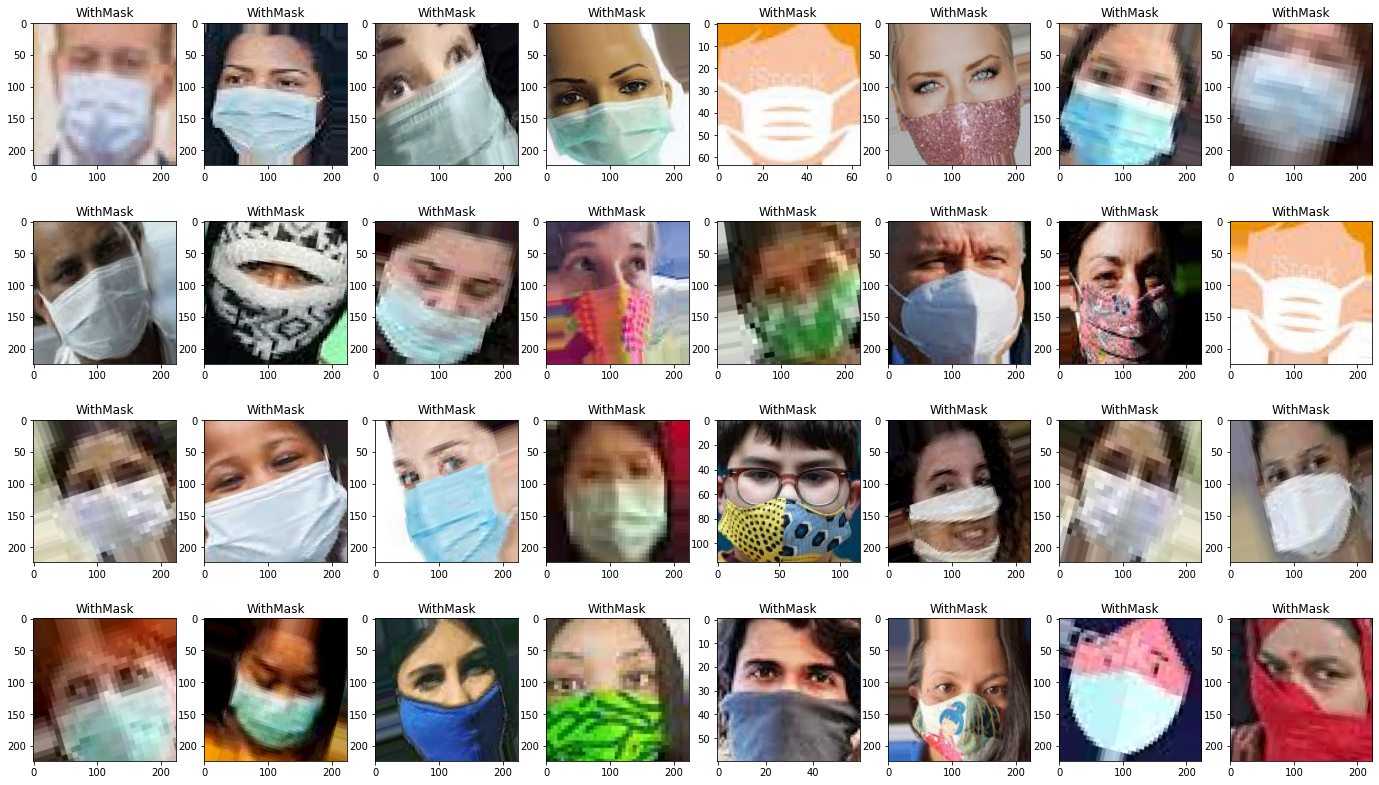

In [18]:
explore_image(withmask_explore)

Berdasarkan sampel visualisasi gambar pada kelas WithMask diketahui bahwa terdpat gambar perempuan dan laki-laki yang memakai masker. Etnis orang yang memakai masker pun cukup beragam. Selain itu usia orang yan memakai masker juga tampak beragam. Gambar juga terlihat diambil dari berbagai sudut yang beragam. Meskipun demikian terlihat bahwa kualitas gambar pada kelas WithMask cukup buruk terlihat dengan beberapa gambar yang blur dan tidak jelas. Terlihat juga gambar yang sangat gelap dan sulit diidentifikasi apakah orang didalam gambar menggunakan masker atau tidak.

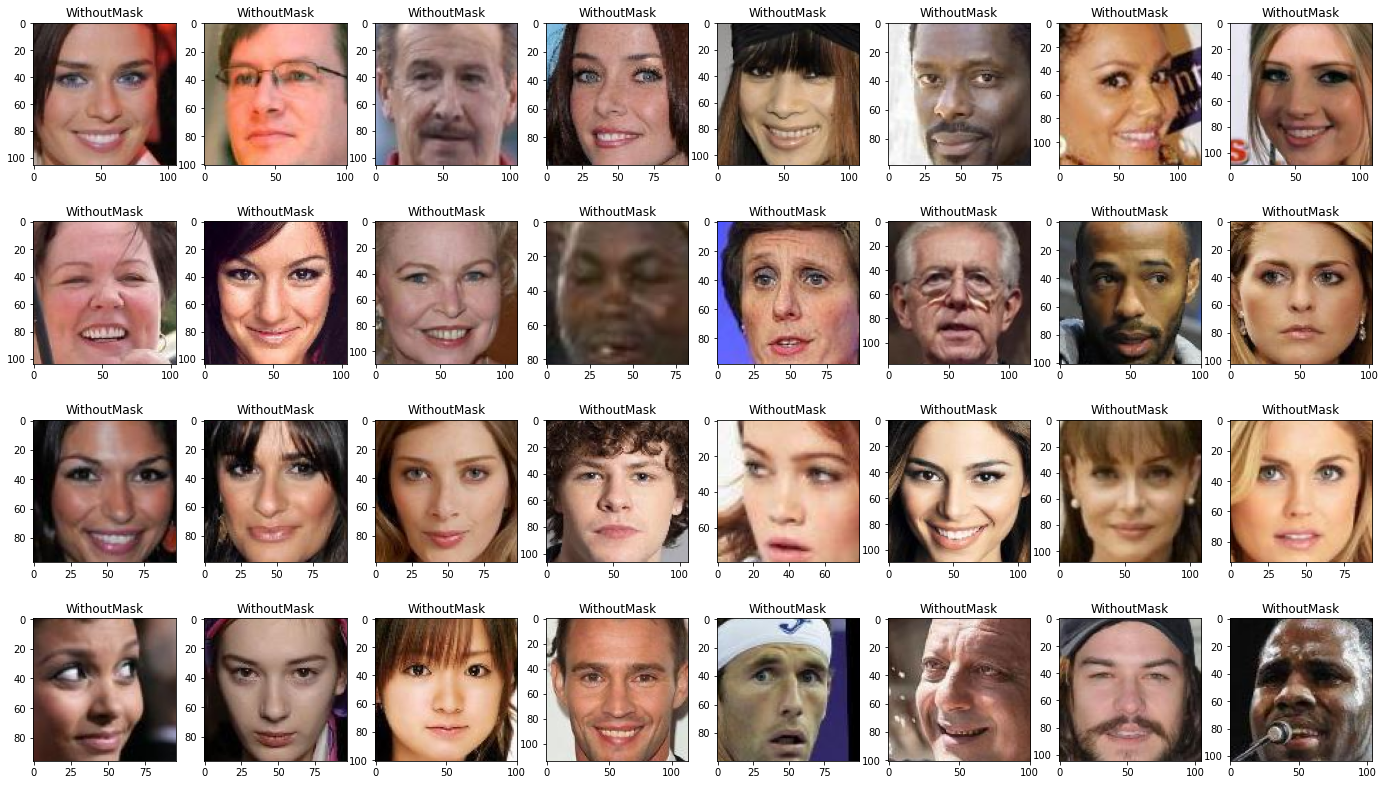

In [19]:
explore_image(withoutmask_explore)

Berdasarkan visuualisasi gambar pada kelas WithoutMask diketahui pada kelas ini terdapat gambar perempuan dan laki-laki tanpa menggunakan masker. Etnisitas dan usia orang pada gambar kelas WithoutMask juga cukup beragam. Sudut pengambilan gambar dalam kelas inin juga cukup beragam. Dibandingkan dengan kualitas gambar pada kelas WithMask, kualitas gambar pada kelas WithoutMask secara garis besar jauh lebih baik.

### 4.3 Image Size

Peneliti ingi mengetahui ukuran gambar dalam dataset.

In [20]:
# Mendefinisikan fungsi untuk melihat ukuran gambar.
def image_shape_df(data):
  height = []
  width = []
  chanels = []
  label = []
  for i in range(len(data)):
    img = cv2.imread(data.iloc[i,0])
    l = data.iloc[i,1]
    h, w, c = img.shape
    height.append(h)
    width.append(w)
    chanels.append(c)
    label.append(l)
    height_df = pd.DataFrame(height, columns=['height'])
    width_df = pd.DataFrame(width, columns=['width'])
    chanels_df = pd.DataFrame(chanels, columns=['chanels'])
    label_df = pd.DataFrame(label, columns=['label'])
    dataframe = pd.concat([height_df, width_df, chanels_df, label_df], axis=1)
  return dataframe

In [21]:
# Membuat dataframe ukuran gambar
shape_df = image_shape_df(train_df)
shape_df

height  width  chanels        label
0        106    106        3  WithoutMask
1        224    224        3     WithMask
2        224    224        3     WithMask
3        224    224        3     WithMask
4        101    101        3  WithoutMask
...      ...    ...      ...          ...
9995     224    224        3     WithMask
9996     106    106        3  WithoutMask
9997     224    224        3     WithMask
9998     105    105        3  WithoutMask
9999      52     52        3     WithMask

[10000 rows x 4 columns]

Peneliti ingin mengetahui rata-rata height, width dan chanels gambar dalam dataset.

In [22]:
shape_df.describe()

height         width  chanels
count  10000.000000  10000.000000  10000.0
mean     153.102800    153.102800      3.0
std       62.948909     62.948909      0.0
min       25.000000     25.000000      3.0
25%      102.000000    102.000000      3.0
50%      115.000000    115.000000      3.0
75%      224.000000    224.000000      3.0
max      563.000000    563.000000      3.0

Diketahui semua gambar memiliki 3 chanels sehingga dapat disimpulkan bahwa semua gambar adalah gambar berwarna. Data mean, std, min, dan max untuk variabel height dan width menunjukan skor yang sama persis sehingga dapat disimpulkan bahwa semua bentuk gambar dalam dataset adalah persegi

Peneliti ingin mengetahui variasi ukuran gambar untuk masing-masing kelas

In [23]:
shape_df.groupby('label')['height'].describe()

count      mean        std   min    25%    50%    75%    max
label                                                                     
WithMask     5000.0  201.6616  55.692242  25.0  224.0  224.0  224.0  563.0
WithoutMask  5000.0  104.5440  10.365305  26.0   99.0  105.0  111.0  156.0

Diketahui skor mean dan std untuk gambar kelas WithMask lebih besar dari pada skor mean dan std kelas WithoutMask. Sehingga dapat disimpulkan bahwa ukuran gambar kelas WithMask lebih bervariasi daripada kelas WithoutMask.

## Bab 5 Data Preprocessing

### 5.1 Get Data Inference

Peneliti akan mengambbil 10 data untuk kelas WithMask dan 10 data untuk kelas WithoutMask secara random untuk keperluan model inference nantinya.

In [24]:
# Mengambil 10 data inference untuk kelas WithMask dan 10 data inference untuk kelas WithoutMask
data_inf_withmask = train_df[(train_df['label']=='WithMask')].sample(20, random_state=32)
data_inf_withoutmask = train_df[(train_df['label']=='WithoutMask')].sample(20, random_state=32)
data_inf_withmask 

images     label
6510  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
3616  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
566   /content/images/Face Mask Dataset/Train/WithMa...  WithMask
1001  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
6921  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
5937  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
2539  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
9305  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
9510  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
3812  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
5992  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
9273  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
7943  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
8500  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
5195  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
5676  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
5355  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
2000  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
2416  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
270   /content/images/Face Mask Dataset/Train/WithMa...  WithMask

In [25]:
# Memisahkan data inference dari dataset keseluruhan
data_train = train_df.drop(data_inf_withmask.index)
data_train = train_df.drop(data_inf_withoutmask.index)

In [26]:
# Melakukan reset index pada data inference dan dataset
data_train.reset_index(drop=True, inplace=True)
data_inf_withmask.reset_index(drop=True, inplace=True)
data_inf_withoutmask.reset_index(drop=True, inplace=True)
data_inf_withmask

images     label
0   /content/images/Face Mask Dataset/Train/WithMa...  WithMask
1   /content/images/Face Mask Dataset/Train/WithMa...  WithMask
2   /content/images/Face Mask Dataset/Train/WithMa...  WithMask
3   /content/images/Face Mask Dataset/Train/WithMa...  WithMask
4   /content/images/Face Mask Dataset/Train/WithMa...  WithMask
5   /content/images/Face Mask Dataset/Train/WithMa...  WithMask
6   /content/images/Face Mask Dataset/Train/WithMa...  WithMask
7   /content/images/Face Mask Dataset/Train/WithMa...  WithMask
8   /content/images/Face Mask Dataset/Train/WithMa...  WithMask
9   /content/images/Face Mask Dataset/Train/WithMa...  WithMask
10  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
11  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
12  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
13  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
14  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
15  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
16  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
17  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
18  /content/images/Face Mask Dataset/Train/WithMa...  WithMask
19  /content/images/Face Mask Dataset/Train/WithMa...  WithMask

In [27]:
# Mengubah data inference menjadi list untuk visualisasi
inf_withmask_preview = data_inf_withmask['images'].tolist()
inf_withoutmask_preview = data_inf_withoutmask['images'].tolist()

In [28]:
# Mendefinisikan fungsi visualisasi
def show_inference(data):
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(20,10))
    for i, data in enumerate(data):
        img = cv2.imread(data)
        ax[i//5, i%5].set_title(data.split('/')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

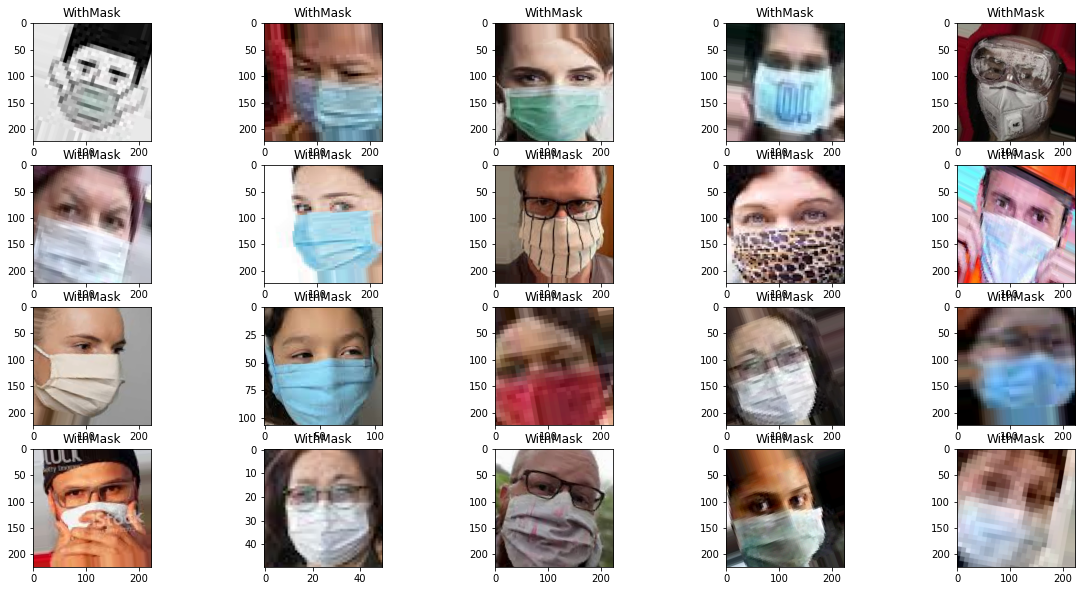

In [29]:
# Visualisasi data inference pada kelas WithMask
show_inference(inf_withmask_preview)

Data inference yang termbil terdiri dari berbagai gambar wajah yang beragam dilihat dari jenis kelamin orang digambar terdapat pria dan wanita, dilihat dari etnisitas juga cukup beragam. Sudut gambar juga bermaca-macam dan tidak hanya wajah menghadap ke depan. Selain itu ada gambar wajah memakai masker yang bukan manusia melaikan ilustrasi kartun.

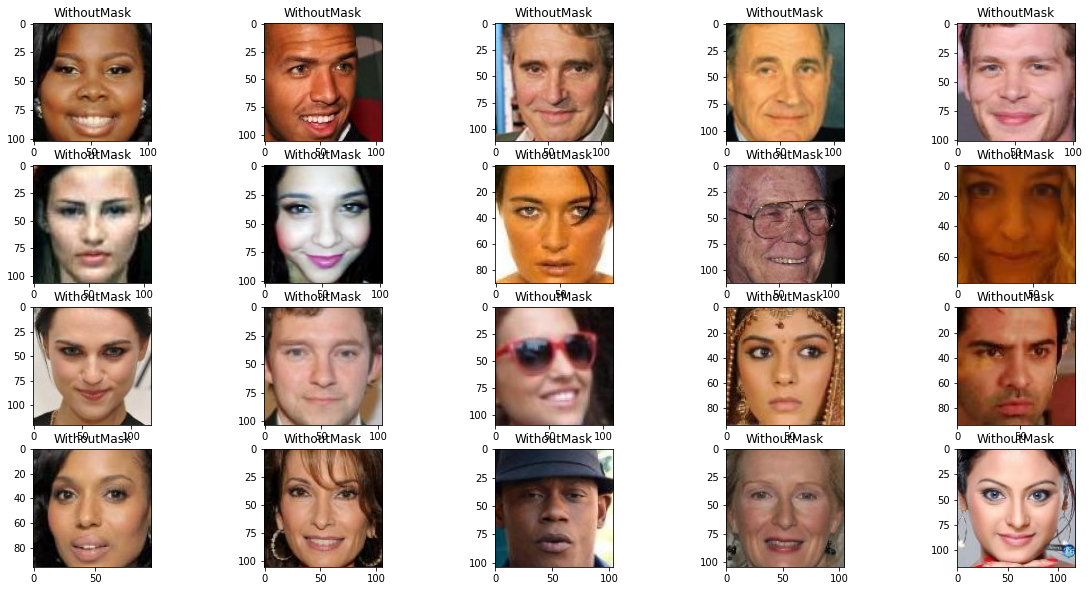

In [30]:
# Visualisasi data inference untuk kelas WithoutMask
show_inference(inf_withoutmask_preview)

Terhihat dari visualisasi diatas terdapat gambar wajah laki-laki dan perempuan. Usia orang pada gambar juga terlihat beragam dari yang tua ke yang muda. Etnisitas pun juga terlihat beragam. Meskipun demikian kebanyakan data inference kelas WithoutMask adalah gambar wajah yang menghadap ke depan.

### 5.2 Image Augmentation

Pada bagian ini akan dilakukan image augmentation pada gambar untuk memperluas dan memperkaya data yang sudah ada menggunakan Image Generator. Jenis Image Augmentation yang akan dilakukan antara lain yaitu :
* rescale : Untuk normalisasi pixel dalam gambar
* rotation : Kebanyakan gambar adalah gambar wajah yang mengahap tegak lurus kedepan sehingga peneliti merasa perlu dilakukan augmentation pada rotasi gambar agar model dapat mempelajari beberapa sudut wajah manusia baik yang memakai masker maupun yang tidak
* width_shift : Untuk menggeser arah gambar sejalan dengan sumbu x atau horizontal. Peneliti merasa penggeseran gambar baik dilakukan agar model dapat mempelajari wajah dari berbagai sisi
* height_shift : Untuk menggeser arah gambar sejalan dengan sumbu y atau vertical. Peneliti menggunakan teknink augmentasi ini agar model dapat mempelajari wajah dari sisi atas dan bawah
* shear_intensity : Untuk melakukan transveksi yaitu menggeser gambar ke arah sumbu x dan y. Hal ini dilakukan agar model dapat mempelajari gambar dengan sudut dan sisi yang berbeda.
* horizontal_flip : Untuk membalik gambar secara horizontal. Peneliti menggunakan augmentasi ini agar model dapat mempelajari gambar dari sisi kiri maupun sisi kanan.

Proses augmentasi tersebut hanya akan dilakukan pada data train. Untuk data validasi dan test proses augmentasi yang dilakukan adalah normalisasi pixel dengan rescale

In [31]:
# Mendefinisikan augmentasi gambar pada data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=5,
    fill_mode='nearest',
    horizontal_flip=True)

# Mendefinisikan Augmentasi gambar pada data validation dengan rescale
vaL_datagen = ImageDataGenerator(rescale=1./255)

# Mendefinisikan augmentasi gambar pada data validation dengan rescale
test_datagen = ImageDataGenerator(rescale=1./255)

Peneliti akan melakukan penyeragaman ukuran gambar untuk pelatihan model yaitu dengan merujuk pada rata-rata ukuran gambar yaitu height 153 dan width 153 yang akan dibulatkan ke bawah menjadi height 150 dan width 150

In [32]:
# Mendefinisikan ukuran gambar dan batch
img_height = 150
img_width = 150
batch = 256

In [33]:
# Mengambil data gambar train dari dataframe dan juga melakukan augmentasi pada data
train_augment = train_datagen.flow_from_dataframe(dataframe=train_df, 
                                                  x_col='images', y_col='label', 
                                                  batch_size=batch, 
                                                  target_size=(img_height, img_width),
                                                  class_mode='binary',
                                                  shuffle=True, seed=32)

# Mengambil data gambar validation dari dataframe dan juga melakukan augmentasi pada data
val_dataset = vaL_datagen.flow_from_dataframe(dataframe=val_df,
                                              x_col='images',
                                              y_col='label',
                                              target_size=(img_height, img_width),
                                              class_mode='binary',
                                              batch_size=batch,
                                              shuffle=False,
                                              seed=32)

# Mengambil data gambar test dari dataframe dan juga melakukan augmentasi pada data
test_dataset = test_datagen.flow_from_dataframe(dataframe=test_df,
                                          x_col='images',
                                          y_col='label',
                                          target_size=(img_height, img_width),
                                          class_mode='binary',
                                          batch_size=batch,
                                          shuffle=False,
                                          seed=32)


Found 10000 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.
Found 992 validated image filenames belonging to 2 classes.


In [34]:
# Melakukan pengecekan kelas gambar
train_augment.class_indices

{'WithMask': 0, 'WithoutMask': 1}

Diketahui kelas 0 adalah kelas WithMask dan kelas 1 adalah kelas WithoutMask

Peneliti akan melakukan pengecekan terhadap hasil image augmentation pada data train

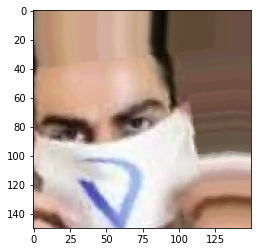

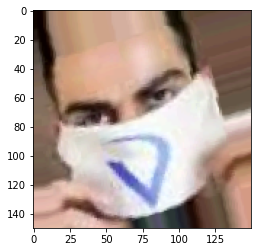

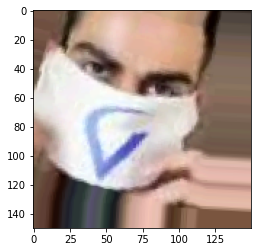

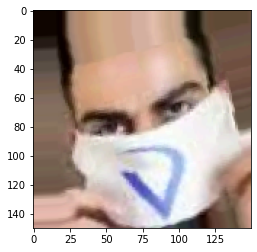

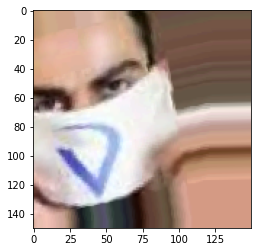

In [35]:
# Mendefinisikan gambar yang akan dichek pada data train
augmented_images = [train_augment[0][0][0] for i in range(5)]

# Melakukan visualisasi pada gambar yang akan dicek
for i in range(5):
    img = augmented_images
    plt.imshow(img[i])
    plt.show()

Diketahui setelah dilakukan image augmentation terdapat gambar dari berbadai sudut berbeda pada wajah yang sama. Sehingga image augmentation yang dilakukan sudah sesuai dengan yang peneliti harapkan.

## Bab 6 Model Definition

Pada penelitian ini akan digunakan 4 model berbeda menggunakan transfer learning dengan model yang sudah teruji sebelumnya dalam melakukan proses image classification. Model yang akan dipakai adalah ResNet50V2, DenseNet201 dan satu model CNN yang akan peneliti buat.

### 6.1 Model ResNet50V2

Model ini dipilih karena model tersebut memiliki skor akurasi yang cukup baik yaitu top 1 accuracy 76% dan top 5 accuracy 93% menurut Keras.io. Pada penelitian ini model akan memprediksi dengan satu output kelas. Menurut peneliti skor accuracy 76% sudah cukup tinggi dalam mengklasifikasikan objek. Selain itu model ini juga dipilih karena ukurannya yang cukup kecil yaitu 98 mb. Peneliti memilih model dengan ukuran yang kecil karena dengan pertimbangan limitasi deploy heroku yang hanya menerima 1 gb file.

Peneliti akan menggunakan model tersebut tanpa mengikutsertakan layer teratasnya. Peneliti juga akan membekukan model untuk mempersingkat waktu training dan juga mendefinisikan output layer yang baru, sesuai dengan tujuan prediksi model dalam penelitian.

source : https://keras.io/api/applications/

In [36]:
# Mendefinisikan model ResNet50V2
resnet = ResNet50V2(weights='imagenet',include_top=False,input_shape=(150,150,3))
# Membekukan model ResNet50V2 agar mempersingkat waktu pelatihan
for layer in resnet.layers:
    layer.trainable = False

In [37]:
# Mendefinisikan model sequnetial untuk transfer learning
model_resnet = Sequential()
# Menambahkan model ResNet50V2 dalam model sequential baru
model_resnet.add(resnet)
# Menambahkan layer Flatten untuk mereduksi dimensi input model
model_resnet.add(Flatten())
# Menambahkan layer dropout untuk mencegah model overfit
model_resnet.add(Dropout(rate=0.2))
# Menambahkan layer output dengan aktivasi sigmoid untuk klasifikasi biner
model_resnet.add(Dense(1, activation='sigmoid'))

In [38]:
# Gambaran arsitektur model
model_resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dropout (Dropout)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 1)                 51201     
                                                                 
Total params: 23,616,001
Trainable params: 51,201
Non-trainable params: 23,564,800
_________________________________________________________________


### 6.2 Model DenseNet201

Peneliti memilih model ini dengan merujuk pada Keras.io yang memaparkan bahwa model memiliki top 1 accuracy 77.3% dan top 5 accuracy 93.6%. Pada penelitian ini klasifikasi kelas yang dilakukan memiliki satu output. Sehingga skor accuracy 77.3% dirasa cukup baik. Selain itu pertimbangan lain yang dilakukan dalampemilihan model adalah dengan melihat ukuran model. Model DenseNet201 memiliki ukuran 80 mb. Pertimbangan dengan melihat ukuran model dilakukan karena adanya limitasi untuk deploy heroku sebesar 1 gb. Peneliti akan menggunakan transfer learning pada model dengan membuang layer tratas pada model tersebut dan menambahkan output layer baru.

source : https://keras.io/api/applications/

In [39]:
# Mendefinisikan model DenseNet201
densenet = DenseNet201(weights='imagenet',include_top=False,input_shape=(150,150,3))
# Membekukan model DenseNet201 agar mempersingkat waktu pelatihan
for layer in densenet.layers:
    layer.trainable = False

In [40]:
# Mendefinisikan model sequnetial untuk transfer learning
model_densenet = Sequential()
# Menambahkan model DenseNet201 dalam model sequential baru
model_densenet.add(densenet)
# Menambahkan layer Flatten untuk mereduksi dimensi input model
model_densenet.add(Flatten())
# Menambahkan layer dropout untuk mencegah model overfit
model_densenet.add(Dropout(rate=0.2))
# Menambahkan layer output dengan aktivasi sigmoid untuk klasifikasi biner
model_densenet.add(Dense(1, activation='sigmoid'))

In [41]:
# Gambaran arsitektur model
model_densenet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 flatten_1 (Flatten)         (None, 30720)             0         
                                                                 
 dropout_1 (Dropout)         (None, 30720)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 30721     
                                                                 
Total params: 18,352,705
Trainable params: 30,721
Non-trainable params: 18,321,984
_________________________________________________________________


### 6.3 Model CNN

Model terakhir adalah model CNN yang akan peneliti buat sendiri. Model CNN akan dibuat dengan menggunakan arsitektur Sequntial API. Model CNN akan dibuat dengan beberapa jenis layer. Jenis Layer yang pertama adalah layer convolution yaitu Conv2D yang berfungsi untuk mengambil feature pixel dari gambar dengan mengalikannya dengan convolution kernel. Selanjutnya ada layer MaxPooling2D yang berfungsi untuk mengelopokkkan pixel dan menggabungkanya menjadi kelompok pixel baru. Ketiga ada Flatten layer yang berfungsi untuk mereduksi dimensi input menjadi vector sebelum dilakukan training. Keempat ada layer Dense yang berisi neruon tempat pelatihan model dilakukan. Kelima ada BatchNormalization layer yang berfungsi untuk menyeragamkan mean dari standar deviasi dari weight saat training. Kemudian terdapat layer Dropout yang berfungsi untuk mematikan neuron agar tidak terjadi overfitting.


In [42]:
model_cnn = Sequential([
    # Menambahkan layer Convolution dengan filter 16
    Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= (150,150,3)),
    MaxPooling2D(pool_size=2, strides=2),
    # Menambahkan layer Convolution dengan filter 32
    Conv2D(filters=32, kernel_size=3, activation= 'relu'),
    MaxPooling2D(pool_size=2, strides=2),
    # Menambahkan layer Convolution dengan filter 64
    Conv2D(filters=64, kernel_size=3, activation= 'relu'),
    MaxPooling2D(pool_size=2, strides=2),
    # Menambahkan layer Flatten untuk mereduksi dimensi input
    Flatten(),
    # Menambahkan hidden layer dengan 128 neuron
    Dense(128, activation='relu'),
    # Menambahkan batch normalization
    BatchNormalization(),
    # Menambahkan hidden layer dengan 64 neuron
    Dense(64, activation='relu'),
    # Menambahkan layer Dropout
    Dropout(rate=0.2),
    #Menambahkan output layer dengan activation sigmoid
    Dense(1, activation='sigmoid')
])

In [43]:
# Gambaran arsitektur model
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

## Bab 7 Model Training

Pada bagian ini peneliti akan melakukan training pada masing-masing model dengan data yang sudah dilakukan preprocessing.Peneliti akan melakukan training pada model dengan beberapa parameter sebagai berikut :
* optimizer : Adam, karena optimizer adam adalah optimizer yang paling populer digunakan dan menjadi best practice untuk menggunakannya pada awal pembuatan model
* loss : binary_crossentropy, karena target yang akan diprediksi adalah kelas biner. Sehingga peneliti merasa penggunakan loss tersebut adalah yang paling tepat.
* metric : recall, karena dalam penelitian ini penting agar prediksi tidak memiliki false negative yang tinggi, sehingga metric recall baik digunakan untuk mengevaluasi performa model

Selain hyperparameter tersebut peneliti juga akan menggunakan parameter callback yaitu early stopping untuk efisiensi waktu trainign model dan modelchekpoint untuk menyimpan perfrma model terbaik.

### 7.1 Model ResNet50V2 Training

In [44]:
# Mendifinisikan callbacks untuk efisiensi waktu training
callbacks1 = [ 
    EarlyStopping(monitor = 'val_loss', patience = 3), 
    ModelCheckpoint('model_resnet.hdf5', monitor='val_loss', save_best_only=True)]

In [45]:
# Memasukkan hyperparameter pada model
model_resnet.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics = [Recall()])

In [46]:
# Melakukan training dengan 10 kali epochs
resnet_history = model_resnet.fit(train_augment,
                        validation_data=val_dataset,
                        epochs=32,
                        callbacks = callbacks1)

Epoch 1/32
40/40 [==============================] - 74s 2s/step - loss: 0.1440 - recall: 0.9730 - val_loss: 0.0039 - val_recall: 0.9975
Epoch 2/32
40/40 [==============================] - 67s 2s/step - loss: 0.0524 - recall: 0.9942 - val_loss: 8.8592e-05 - val_recall: 1.0000
Epoch 3/32
40/40 [==============================] - 63s 2s/step - loss: 0.0362 - recall: 0.9946 - val_loss: 1.6751e-05 - val_recall: 1.0000
Epoch 4/32
40/40 [==============================] - 63s 2s/step - loss: 0.0165 - recall: 0.9970 - val_loss: 1.0433e-04 - val_recall: 1.0000
Epoch 5/32
40/40 [==============================] - 65s 2s/step - loss: 0.0240 - recall: 0.9960 - val_loss: 1.0311e-04 - val_recall: 1.0000
Epoch 6/32
40/40 [==============================] - 63s 2s/step - loss: 0.0075 - recall: 0.9982 - val_loss: 1.5806e-04 - val_recall: 1.0000


### 7.2 Model DenseNet201 Training

In [47]:
# Mendifinisikan callbacks untuk efisiensi waktu training
callbacks2 = [ 
    EarlyStopping(monitor = 'val_loss', patience = 3), 
    ModelCheckpoint('model_densenet.hdf5', monitor='val_loss', save_best_only=True)]

In [48]:
# Memasukkan hyperparameter pada model
model_densenet.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics = [Recall()])

In [49]:
# Melakukan training dengan 10 kali epochs
densenet_history = model_densenet.fit(train_augment,
                        validation_data=val_dataset,
                        epochs=32,
                        callbacks = callbacks2)

Epoch 1/32
40/40 [==============================] - 92s 2s/step - loss: 0.1134 - recall_1: 0.9558 - val_loss: 0.0059 - val_recall_1: 0.9975
Epoch 2/32
40/40 [==============================] - 69s 2s/step - loss: 0.0219 - recall_1: 0.9924 - val_loss: 0.0024 - val_recall_1: 1.0000
Epoch 3/32
40/40 [==============================] - 69s 2s/step - loss: 0.0172 - recall_1: 0.9936 - val_loss: 0.0011 - val_recall_1: 1.0000
Epoch 4/32
40/40 [==============================] - 66s 2s/step - loss: 0.0156 - recall_1: 0.9934 - val_loss: 0.0022 - val_recall_1: 1.0000
Epoch 5/32
40/40 [==============================] - 69s 2s/step - loss: 0.0100 - recall_1: 0.9962 - val_loss: 0.0010 - val_recall_1: 1.0000
Epoch 6/32
40/40 [==============================] - 67s 2s/step - loss: 0.0081 - recall_1: 0.9966 - val_loss: 6.7993e-04 - val_recall_1: 1.0000
Epoch 7/32
40/40 [==============================] - 68s 2s/step - loss: 0.0094 - recall_1: 0.9964 - val_loss: 3.2029e-04 - val_recall_1: 1.0000
Epoch 8/32
4

### 7.3 Model CNN Training

In [50]:
# Mendifinisikan callbacks untuk efisiensi waktu training
callbacks3 = [ 
    EarlyStopping(monitor = 'val_loss', patience = 3), 
    ModelCheckpoint('model_cnn.hdf5', monitor='val_loss', save_best_only=True)]

In [51]:
# Memasukkan hyperparameter pada model
model_cnn.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics = [Recall()])

In [52]:
# Melakukan training dengan 10 kali epochs
cnn_history = model_cnn.fit(train_augment,
                        validation_data=val_dataset,
                        epochs=32,
                        callbacks = callbacks3)

Epoch 1/32
40/40 [==============================] - 62s 1s/step - loss: 0.2633 - recall_2: 0.9104 - val_loss: 0.4342 - val_recall_2: 0.6525
Epoch 2/32
40/40 [==============================] - 58s 1s/step - loss: 0.1493 - recall_2: 0.9668 - val_loss: 0.2925 - val_recall_2: 0.7475
Epoch 3/32
40/40 [==============================] - 58s 1s/step - loss: 0.1140 - recall_2: 0.9672 - val_loss: 0.1527 - val_recall_2: 0.9500
Epoch 4/32
40/40 [==============================] - 60s 1s/step - loss: 0.0963 - recall_2: 0.9750 - val_loss: 0.1519 - val_recall_2: 0.9025
Epoch 5/32
40/40 [==============================] - 58s 1s/step - loss: 0.0969 - recall_2: 0.9712 - val_loss: 0.1027 - val_recall_2: 0.9375
Epoch 6/32
40/40 [==============================] - 59s 1s/step - loss: 0.0815 - recall_2: 0.9758 - val_loss: 0.0784 - val_recall_2: 0.9650
Epoch 7/32
40/40 [==============================] - 58s 1s/step - loss: 0.0674 - recall_2: 0.9816 - val_loss: 0.0624 - val_recall_2: 0.9900
Epoch 8/32
40/40 [==

## Bab 8 Model Evaluation

### 8.1 Model ResNet50V2 Evaluation

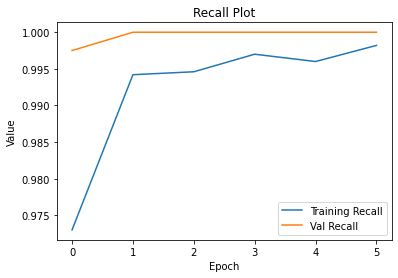

In [53]:
# Visualisasi skor recall dalam training model ResNet50V2
plt.plot(resnet_history.history['recall'], label='Training Recall')
plt.plot(resnet_history.history['val_recall'], label='Val Recall')
plt.title('Recall Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

Berdasarkan visualisasi diatas dapat terlihat bahwa skor recall data validation stagnan di ankga 1. Sedangkan skor recall untuk data train terlihat mengalami banyak kenaikan. Jika melihat tren performanya maka ada indikasi bahwa skor recall untuk data train mengalami kenaikan jika epoch pelatihan ditambahkan, akan tetapi tidak terdapat indikasi skor akan konvergen dengan data validation.

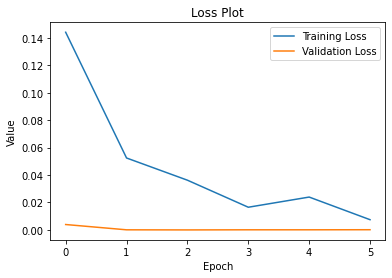

In [54]:
# Visualisasi skor loss dalam training model ResNet50V2
plt.plot(resnet_history.history['loss'], label='Training Loss')
plt.plot(resnet_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

Melihat visualisasi skor loss untuk model ResNet50V2 ditemukan bahwa skor loss data train mengalami banyak kenaikan dan penurunan selama pelatihan model. Melihat tren kenaikan dan penurunan tersebut terindikasi skor mengalami penurunan dengan penambahan epoch. 

In [55]:
result_train_resnet = model_resnet.evaluate(train_augment, batch_size=256)
result_test_resnet = model_resnet.evaluate(test_dataset, batch_size=256)
print('Train - Loss     : ', result_train_resnet[0])
print('Train - Accuracy : ', result_train_resnet[1])
print('')
print('Test - Loss     : ', result_test_resnet[0])
print('Test - Accuracy : ', result_test_resnet[1])
print('')

4/4 [==============================] - 5s 1s/step - loss: 0.0197 - recall: 0.9961
Train - Loss     :  0.005344316828995943
Train - Accuracy :  0.9994000196456909

Test - Loss     :  0.019743768498301506
Test - Accuracy :  0.9960707426071167



Dari hasil evaluasi model diketahui skor recall untuk prediksi data train adalah  0.99 dan data test 0.99. Melihat skor tersebut dapat dikatakan kedua skor cukup tinggi dan tidak ditemukan selisih skor yang jauh. Sehingga model dapat disimpulkan adalah goodfit

In [56]:
# Mendefinisikan pemetaan label untuk dibandingkan dengan prediksi model
label_map = {'WithMask': 0, 'WithoutMask' : 1 }

# Mengubah label menjadi angka
y_test_eval = test_df['label'].map(label_map)

In [57]:
# Melakukan prediksi dengan model ResNet50V2 pada data test
y_pred_test_resnet = (model_resnet.predict(test_dataset) > 0.5)*1

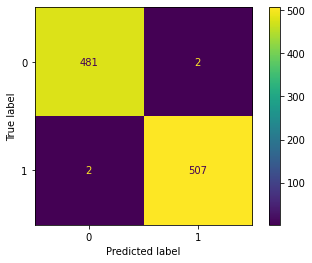

In [58]:
# Mendefinisikan kelas prediksi untuk condusion matrix
classes = [0, 1]

# Membuat confusion matrix berdasarkan prediksi data train
cm = confusion_matrix(y_test_eval, y_pred_test_resnet, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)

disp.plot()
plt.show()

Berdasarkan confusion matrix ditemukan 2 False Negative yaitu saat model memprediksi gambar wajah tanpa masker sebagai wajah dengan masker dan 2 False Positive yaitu saat model memprediksi gambar wajah tanpa masker sebagai dengan masker. Melihat jumlah False Positive dan False Negative tersebut dapat disimpulkan model dapat memprediksi gambar wajah tanpa masker dengan cukup baik.

In [59]:
print(classification_report(y_test_eval,y_pred_test_resnet))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       483
           1       1.00      1.00      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



Berdasarkan classification report dapat terlihat bahwa skor yang tertampil baik recall, precision maupun F1 skor menunjukkan angka yan tinggi. Hal tersebut karena seperti yang telihat pada confusion matriks tidak terdapat banyak kesalahan pada prediksi yang dibuat model. Sehingga dapat disimpulkan bahwa model mampu mengklasifikasikan dataset kedalam dua kelas dengan baik.

Peneliti ingin melakukan eksplorasi terhadap kesalahan prediksi yang dilakukan oleh model.

In [60]:
# Memasukkan hasil prediksi model dan encoding label dalam dataframe
test_df['eval'] = y_test_eval
test_df['resnet'] = y_pred_test_resnet

In [149]:
# Melakukan query pada kesalahan prediksi model
resnet_miss = test_df.query('eval != resnet')
resnet_miss

images        label  eval  \
360  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
375  /content/images/Face Mask Dataset/Test/Without...  WithoutMask     1   
939  /content/images/Face Mask Dataset/Test/Without...  WithoutMask     1   
980  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   

     resnet  densenet  cnn  resnet_imp  densenet_imp  cnn_imp  
360       1         0    0           0             0        0  
375       0         0    1           0             0        1  
939       0         1    1           0             1        1  
980       1         0    0           0             0        1

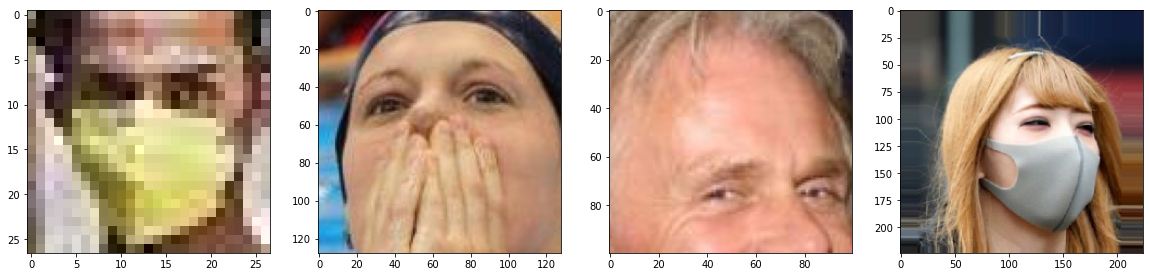

In [165]:
resnet1 = plt.imread(resnet_miss.iloc[0,0])
resnet2 = plt.imread(resnet_miss.iloc[1,0])
resnet3 = plt.imread(resnet_miss.iloc[2,0])
resnet4 = plt.imread(resnet_miss.iloc[3,0])

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,10))
ax[0].imshow(resnet1)
ax[1].imshow(resnet1)
ax[2].imshow(resnet1)
ax[3].imshow(resnet1)

Berdasarkan visualisasi pada data yang gagal diprediksi dengan benar oleh model ResNet50V2 ditemukan bahwa model tidak bisa memprediksikan gambar wajah untuk kelas WithMask ketika gambar tersebut memiliki resolusi rendah dan ketika orang pada gambar memejamkan mata. Pada gambar yang beresolusi rendah mungkin model tidak mendapatkan input yang cukup baik sehingga terjadi kesalahan prediksi. Pada orang yang sedang memejamkan mata, ada kemungkinan bahwa fitur mata adalah salah satu fitur yang penting dalam deteksi wajah sehingga ketika matanya tidak terlihat model gagal melakukan prediksi.

Selain itu model juga gagal dalam melakukan prediksi pada kelas WithoutMask ketika orang dalam gambar menutupi mulutnya dengan tangan dan ketika gambar wajah yang terlihat hanya matanya saja. Model mungkin melakukan kesalahan prediksi pada orang yang menutupi mukanya dengan tangan karena tangan tersebut dideteksi sebagai masker. Kemudian kesalahan pada gambar orang yang hanya terlihat matanya saja diperidksikan sebagai orang yang menggunakan masker mungkin karena bagian yang seharusnya ditutupi masker tidak terlihat sehingga model memprediksikan orang tersebut memakai masker padahal tidak.

### 8.2 Model DenseNet201 Evaluation

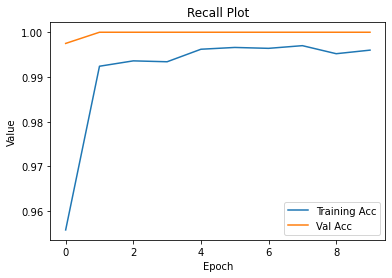

In [65]:
# Visualisasi skor recall Model DenseNet201 selama model training
plt.plot(densenet_history.history['recall_1'], label='Training Acc')
plt.plot(densenet_history.history['val_recall_1'], label='Val Acc')
plt.title('Recall Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

Melihat pada visualisasi performa model DenseNet201 selama training ditemukan skor recall yang stagnan pada angka 1 untuk data validation. Sementara itu untuk data train skor recall terlihat mengalami kenaikan selama pelatihan. Jika dilihat dari tren performa model maka tidak perlu dilakukan penambahan epoch karena tidak terlihat adanya indikasi konvergen antara skor recall data train dan data validation.

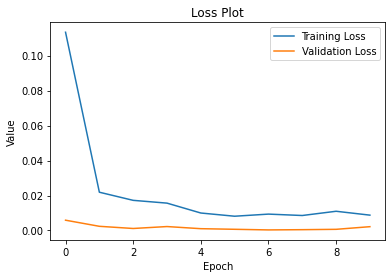

In [66]:
# Visualisasi skor loss Model DenseNet201 selama model training
plt.plot(densenet_history.history['loss'], label='Training Loss')
plt.plot(densenet_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

Berdasarkan visualisasi diatas dapat terlihat bahwa skor loss untuk data train memiliki tren penurunan . Sedangkan skor loss untuk data validation meskipun tedapat beberapa kenaikan tetapi trennya cukup stagnan. Melihat kedua tren tersebut tidak ada indikasi bahwa menambah epoch akan meningkatkan perfoma model.

In [67]:
# Melakukan model evaluasi dengan metric recall
result_train_densenet = model_densenet.evaluate(train_augment, batch_size=256)
result_test_densenet = model_densenet.evaluate(test_dataset, batch_size=256)
print('Train - Loss     : ', result_train_densenet[0])
print('Train - Accuracy : ', result_train_densenet[1])
print('')
print('Test - Loss     : ', result_test_densenet[0])
print('Test - Accuracy : ', result_test_densenet[1])
print('')

4/4 [==============================] - 9s 3s/step - loss: 0.0080 - recall_1: 0.9961
Train - Loss     :  0.00898665189743042
Train - Accuracy :  0.9990000128746033

Test - Loss     :  0.008011720143258572
Test - Accuracy :  0.9960707426071167



Diketahui dari evaluasi model dengan menggunakan metric recall ditemukan skor pada data train sebesar 0.99 dan skor pada data test sebesar 0.99. Melihat kedua skor tersebut tidak ditemukan selisih yang jauh antara keduanya dan juga kedua skor tersebut tergolong tinggi maka dapat disimpulkan bahwa model goodfit.

In [69]:
# Melakukan prediksi model terhadap data test
y_pred_test_densenet = (model_densenet.predict(test_dataset) > 0.5)*1

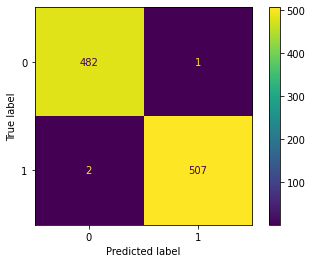

In [70]:
# Membuat confusion matrix berdasarkan prediksi data train
cm = confusion_matrix(y_test_eval, y_pred_test_densenet, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)

disp.plot()
plt.show()

Merujuk pada confusion matrix diatas, ditemukan False Negative sebanyak 2 prediksi yaitu saat model memprediksi gambar wajah tanpa masker sebagai dengan masker dan tidak ada sama sekali False Positive yaitu ketika model memprediksikan wajah dengan masker sebagai wajah tanpa masker. Sehingga dapat disimpulkan model dapat mengklasifikasikan data kedalam dua kelas dengan baik.

In [71]:
# Membuat classification matrix berdasarkan prediksi data test
print(classification_report(y_test_eval,y_pred_test_densenet))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       483
           1       1.00      1.00      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



Melihat pada classification report di atas dapat terlihat bahwa terdapat nilai yang sama pada semua metric yaitu satu. Nilai tersebut mungkin terjadi akibat pembulatan karena classification report hanya menampilkan satu desimal saja. Pada prediksi model skor satu adalah hal yang sangat jarang terjadi dan terdapat indikasi overfit, sehingga mungkin diperlukan suatu perubahan pada model untuk mencegah hal tersebut.

In [72]:
test_df['densenet'] = y_pred_test_densenet

In [166]:
# Melakukan query pada kesalahan prediksi model
den_miss = test_df.query('eval != densenet')
den_miss

images        label  eval  \
375  /content/images/Face Mask Dataset/Test/Without...  WithoutMask     1   
457  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
963  /content/images/Face Mask Dataset/Test/Without...  WithoutMask     1   

     resnet  densenet  cnn  resnet_imp  densenet_imp  cnn_imp  
375       0         0    1           0             0        1  
457       0         1    1           0             0        1  
963       1         0    1           0             0        1

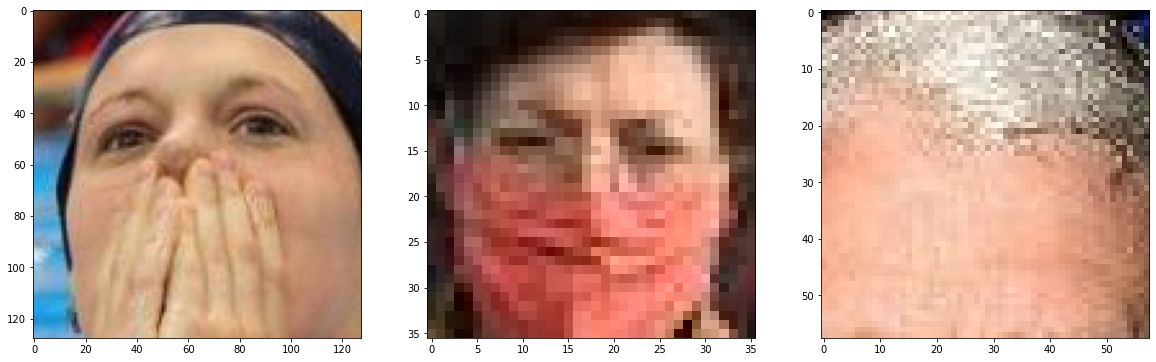

In [167]:
den1 = plt.imread(den_miss.iloc[0,0])
den2 = plt.imread(den_miss.iloc[1,0])
den3 = plt.imread(den_miss.iloc[2,0])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,10))
ax[0].imshow(den1)
ax[1].imshow(den2)
ax[2].imshow(den3)

Pada model DenseNet201 berdsarkan visualisasi kesalah prediksi model ditemukan gambar yang sama dengan kesalahan model ResNet50V2 yaitu gamabar orang yang menutupi mulutnya dengan tangan. Selain itu tampak gambar seseorang yang sepertinya hanya kepalanya saja diperdiksi menjadi kelas WithMask. Kesalahan tersebut mungkin terjadi karena resolusi gambar yang jelek menyebabkan model kesulitan melakukan identifikasi. Terakhir ditemukan gamabr orang dengan maske tetapi diprediksi model tidak menggunakan masker. Kesalahan pada prediksi ini kemungkinan juga karena resolusi gambar yang kurang baik.

### 8.3 Model CNN Evaluation

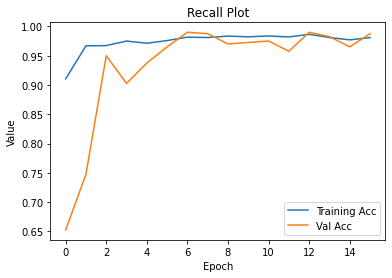

In [74]:
# Visualisasi skor recall pada Model CNN selama model training
plt.plot(cnn_history.history['recall_2'], label='Training Acc')
plt.plot(cnn_history.history['val_recall_2'], label='Val Acc')
plt.title('Recall Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

Diketahui dari visualisasi diatas bahwa skor recall data train cenderung memiliki kenaikan dan penurunan yang tidak terlalu jauh dibandingkan dengan data validation. Skor recall pada data train cenderun memiliki tren yang stagnan. 

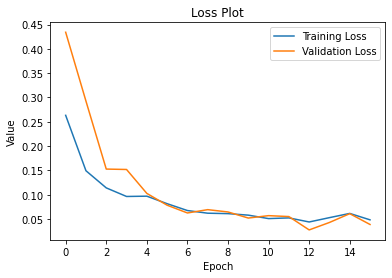

In [75]:
# Visualisasi skor recall pada Model CNN selama model training
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

Melihat visualisasi diatas ditemukan bahwa tren skor loss untuk data train terlihat mengalami penurunan. Hal yang sama juga ditemukan ketika melihat tren skor loss untuk data validation meskipun ditemukan kenaikan di akhir epoch. 

In [76]:
# Melakukan evaluasi pada model dengan metric recall
result_train_cnn = model_cnn.evaluate(train_augment, batch_size=256)
result_test_cnn = model_cnn.evaluate(test_dataset, batch_size=256)
print('Train - Loss     : ', result_train_cnn[0])
print('Train - Accuracy : ', result_train_cnn[1])
print('')
print('Test - Loss     : ', result_test_cnn[0])
print('Test - Accuracy : ', result_test_cnn[1])
print('')

4/4 [==============================] - 2s 626ms/step - loss: 0.0330 - recall_2: 0.9921
Train - Loss     :  0.044441550970077515
Train - Accuracy :  0.9922000169754028

Test - Loss     :  0.0330059677362442
Test - Accuracy :  0.9921414256095886



Berdasarkan evaluasi prediksi model dengan metric recall, diemukan skor 0.99 pada prediksi data train dan 0.99 pada prediksi data test. Kedua skor tersebut adalah skor yang cukup tinggi dan juga tidak memiliki selisih yang jauh sehingga dapat dikatakan model adalah goodfit.

In [77]:
# Melakukan prediksi dengan Model CNN terhadap data test
y_pred_test_cnn = (model_cnn.predict(test_dataset) > 0.5)*1

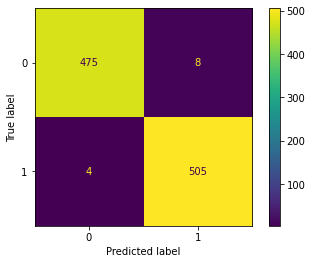

In [78]:
# Membuat confusion matrix berdasarkan prediksi data test
cm = confusion_matrix(y_test_eval, y_pred_test_cnn, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)

disp.plot()
plt.show()

Merujuk pada confusion matrix diatas, ditemukan 8 False Positive yaitu ketika model salah memprediksi gambar wajah dengan masker sebagai tanpa masker dan 4 False Negative yaitu ketika model salah memprediksi gambar wajah tanpa masker sebagai dengan masker. Melihat pada jumlah False Negative dan False Positive yang cukup rendah terutama dalam hal ini False Negative maka dapat disimpulkan model dapat memprediksi kedua kelas dengan baik

In [79]:
print(classification_report(y_test_eval,y_pred_test_cnn))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       483
           1       0.98      0.99      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



Dari classification report diatas dapat terlihat bahwa Model CNN memiliki nilai yang tinggi pada metric recall, precision, dan f1 skor. Dalam penelitian ini metric yang paling penting adalah recall karean peneliti menginginkan False Positive atau model memprediksi gambar wajah tanpa masker sebagai dengan masker sesedikit mungkin. Sehingga skor recall yang tertera pada classification report dirasa sanat baik.

In [80]:
test_df['cnn'] = y_pred_test_cnn

In [173]:
# Melakukan query pada kesalahan prediksi model
cnn_miss = test_df.query('eval != cnn')
cnn_miss

images        label  eval  \
228  /content/images/Face Mask Dataset/Test/Without...  WithoutMask     1   
249  /content/images/Face Mask Dataset/Test/Without...  WithoutMask     1   
261  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
369  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
411  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
417  /content/images/Face Mask Dataset/Test/Without...  WithoutMask     1   
457  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
532  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
573  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
674  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
706  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
777  /content/images/Face Mask Dataset/Test/Without...  WithoutMask     1   

     resnet  densenet  cnn  resnet_imp  densenet_imp  cnn_imp  
228       1         1    0           1             1        1  
249       1         1    0           1             1        0  
261       0         0    1           0             0        1  
369       0         0    1           0             0        0  
411       0         0    1           0             0        1  
417       1         1    0           1             1        1  
457       0         1    1           0             0        1  
532       0         0    1           0             0        1  
573       0         0    1           0             0        1  
674       0         0    1           0             0        1  
706       0         0    1           0             0        1  
777       1         1    0           1             1        1

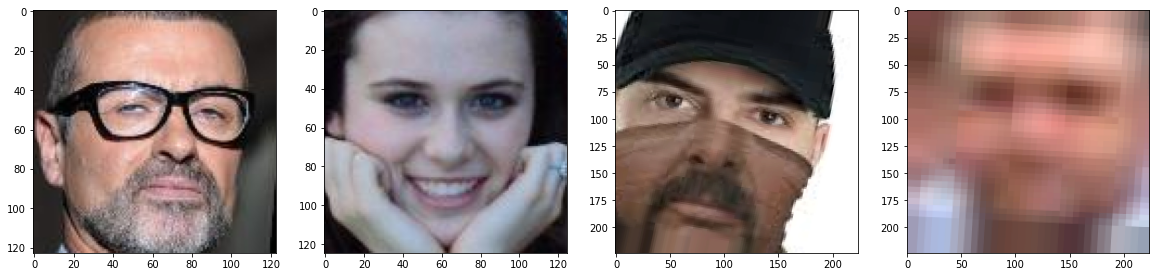

In [176]:
cnn1 = plt.imread(cnn_miss.iloc[0,0])
cnn2 = plt.imread(cnn_miss.iloc[1,0])
cnn3 = plt.imread(cnn_miss.iloc[7,0])
cnn4 = plt.imread(cnn_miss.iloc[10,0])


fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,10))
ax[0].imshow(cnn1)
ax[1].imshow(cnn2)
ax[2].imshow(cnn3)
ax[3].imshow(cnn4)

Dapat dilihat dari sampel kesalahan prediksi gambar diatas bahwa kesalahan prediksi model terjadi karena gambar orang yang memiliki bulu wajah yang cukup lebat yang kemungkinan diprediksi oleh model sebagai masker. Selain itu terdapat gambar seorang wanita yang meletakkan tangan di pipi sambil tersenyum lebar yang diprediksi oleh label sebagai gambar dengan masker. Kesalahan tersebut mungkin terjadi karena model gagal mengidentifikasi ekspresi senyum tersebut sebagai masker. 

Kesalah prediksi pada kelas dengan masker diprediksi sebagai tidak memakai masker ditemukan ketika terdapat gambar orang yang memakai masker dengan motif wajah manusia. Model gagal mengidentifikasi wajah manusia asli dan motif masker tersebut. Selain itu kesalahan pada prediksi gambar dengan masker juga terjadi pada gambar dengan reesolusi yang buruk.

### 8.5 Model Improvement ResNet50V2

Performa Model ResNet50V2 sebenarnya sudah cukup baik, akan tetapi skor recallnya menunjukkan skor yang sangat tinggi sehingga ada indikasi bahwa model mungkin akan sulit untuk mengeneralisasi data lainnya. Sehingga penelit akan melakukan penambahan besaran neruon yang akan dimatikan pada layer Dorpout dalam model.

In [82]:
# Mendefinisikan model sequnetial untuk transfer learning
model_resnet_imp = Sequential()
# Menambahkan model ResNet50V2 dalam model sequential baru
model_resnet_imp.add(resnet)
# Menambahkan layer Flatten untuk mereduksi dimensi input model
model_resnet_imp.add(Flatten())
# Menambahkan layer dropout untuk mencegah model overfit
model_resnet_imp.add(Dropout(rate=0.3))
# Menambahkan layer output dengan aktivasi sigmoid untuk klasifikasi biner
model_resnet_imp.add(Dense(1, activation='sigmoid'))

In [83]:
# Mendefinisikan callback
callbacks4 = [ 
    EarlyStopping(monitor = 'val_loss', patience = 3), 
    ModelCheckpoint('model_resnet_imp.hdf5', monitor='val_loss', save_best_only=True)]

In [84]:
# Memasukkan hyperparameter pada model
model_resnet_imp.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics = [Recall()])

In [85]:
# Melakukan training dengan 10 kali epochs
resnet_history_imp = model_resnet_imp.fit(train_augment,
                        validation_data=val_dataset,
                        epochs=32)

Epoch 1/32
40/40 [==============================] - 67s 2s/step - loss: 0.1102 - recall_3: 0.9780 - val_loss: 1.2433e-05 - val_recall_3: 1.0000
Epoch 2/32
40/40 [==============================] - 66s 2s/step - loss: 0.0398 - recall_3: 0.9946 - val_loss: 6.3598e-05 - val_recall_3: 1.0000
Epoch 3/32
40/40 [==============================] - 67s 2s/step - loss: 0.0271 - recall_3: 0.9946 - val_loss: 7.9859e-04 - val_recall_3: 1.0000
Epoch 4/32
40/40 [==============================] - 63s 2s/step - loss: 0.0157 - recall_3: 0.9964 - val_loss: 3.7688e-05 - val_recall_3: 1.0000
Epoch 5/32
40/40 [==============================] - 65s 2s/step - loss: 0.0209 - recall_3: 0.9966 - val_loss: 9.6296e-06 - val_recall_3: 1.0000
Epoch 6/32
40/40 [==============================] - 62s 2s/step - loss: 0.0153 - recall_3: 0.9972 - val_loss: 5.3259e-06 - val_recall_3: 1.0000
Epoch 7/32
40/40 [==============================] - 61s 2s/step - loss: 0.0122 - recall_3: 0.9972 - val_loss: 1.3122e-05 - val_recall_3:

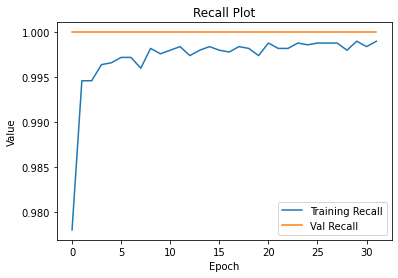

In [86]:
# Visualisasi skor recall dalam training model improvement ResNet50V2
plt.plot(resnet_history_imp.history['recall_3'], label='Training Recall')
plt.plot(resnet_history_imp.history['val_recall_3'], label='Val Recall')
plt.title('Recall Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

Dapat terlihat dari visualisasi preforma model training pada model resnet yang dilakukan dropout lebih banyak menunjukkan tren yang sama seperti sebelumnya untuk skor recall data validation yang stagnan pada ankga satu. Selain itu tren recal data train juga mengalami kenaikan. Setelah dilakukan dropout tidak ditemukan penurunan performa.

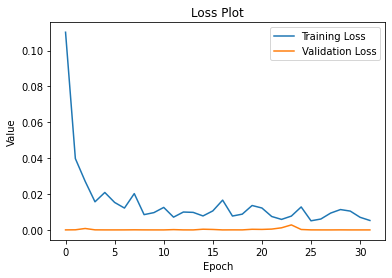

In [87]:
# Visualisasi skor loss dalam training model improvement ResNet50V2
plt.plot(resnet_history_imp.history['loss'], label='Training Loss')
plt.plot(resnet_history_imp.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

Melihat tren untuk skor loss pada data valitaionmasih tetap stagnan mendekati nol dari awal hingga akhir sebelum diperbanyak dropoutnya. Selain itu skor loss data menunjukkan tren penurunan yang cukup stagnan setelah epoch keempat

In [88]:
result_train_resnet_imp = model_resnet_imp.evaluate(train_augment, batch_size=256)
result_test_resnet_imp = model_resnet_imp.evaluate(test_dataset, batch_size=256)
print('Train - Loss     : ', result_train_resnet_imp[0])
print('Train - Accuracy : ', result_train_resnet_imp[1])
print('')
print('Test - Loss     : ', result_test_resnet_imp[0])
print('Test - Accuracy : ', result_test_resnet_imp[1])
print('')

4/4 [==============================] - 2s 402ms/step - loss: 0.0262 - recall_3: 0.9921
Train - Loss     :  0.0036170422099530697
Train - Accuracy :  0.9986000061035156

Test - Loss     :  0.026181643828749657
Test - Accuracy :  0.9921414256095886



In [89]:
# Melakukan prediksi dengan model ResNet50V2 pada data test
y_pred_test_resnet_imp = (model_resnet_imp.predict(test_dataset) > 0.5)*1

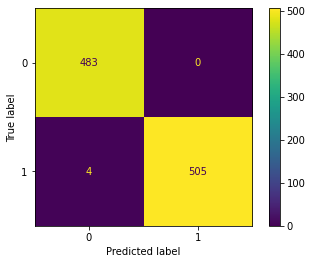

In [90]:
# Membuat confusion matrix berdasarkan prediksi data train
cm = confusion_matrix(y_test_eval, y_pred_test_resnet_imp, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)

disp.plot()
plt.show()

In [91]:
print(classification_report(y_test_eval,y_pred_test_resnet_imp))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       483
           1       1.00      0.99      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



In [92]:
test_df['resnet_imp'] = y_pred_test_resnet_imp

In [177]:
# Melakukan query pada kesalahan prediksi model
res_imp_miss = test_df.query('eval != resnet_imp')
res_imp_miss

images        label  eval  \
375  /content/images/Face Mask Dataset/Test/Without...  WithoutMask     1   
518  /content/images/Face Mask Dataset/Test/Without...  WithoutMask     1   
939  /content/images/Face Mask Dataset/Test/Without...  WithoutMask     1   
963  /content/images/Face Mask Dataset/Test/Without...  WithoutMask     1   

     resnet  densenet  cnn  resnet_imp  densenet_imp  cnn_imp  
375       0         0    1           0             0        1  
518       1         1    1           0             1        1  
939       0         1    1           0             1        1  
963       1         0    1           0             0        1

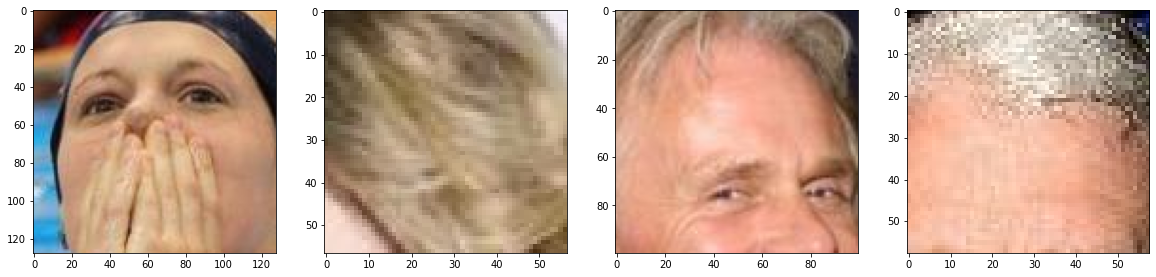

In [178]:
res_imp1 = plt.imread(res_imp_miss.iloc[0,0])
res_imp2 = plt.imread(res_imp_miss.iloc[1,0])
res_imp3 = plt.imread(res_imp_miss.iloc[2,0])
res_imp4 = plt.imread(res_imp_miss.iloc[3,0])


fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,10))
ax[0].imshow(res_imp1)
ax[1].imshow(res_imp2)
ax[2].imshow(res_imp3)
ax[3].imshow(res_imp4)

### 8.5 Model Improvement DenseNet201

In [98]:
# Mendefinisikan model sequnetial untuk transfer learning
model_densenet_imp = Sequential()
# Menambahkan model DenseNet201 dalam model sequential baru
model_densenet_imp.add(densenet)
# Menambahkan layer Flatten untuk mereduksi dimensi input model
model_densenet_imp.add(Flatten())
# Menambahkan layer dropout untuk mencegah model overfit
model_densenet_imp.add(Dropout(rate=0.3))
# Menambahkan layer output dengan aktivasi sigmoid untuk klasifikasi biner
model_densenet_imp.add(Dense(1, activation='sigmoid'))

In [99]:
# Memasukkan hyperparameter pada model
model_densenet_imp.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics = [Recall()])

In [101]:
# Mendifinisikan callbacks untuk efisiensi waktu training
callbacks5 = [ 
    EarlyStopping(monitor = 'val_loss', patience = 3), 
    ModelCheckpoint('model_densenet_imp.hdf5', monitor='val_loss', save_best_only=True)]

In [102]:
# Melakukan training dengan 10 kali epochs
densenet_history_imp = model_densenet_imp.fit(train_augment,
                        validation_data=val_dataset,
                        epochs=32,
                        callbacks = callbacks5)

Epoch 1/32
40/40 [==============================] - 78s 2s/step - loss: 0.0879 - recall_5: 0.9684 - val_loss: 0.0071 - val_recall_5: 0.9975
Epoch 2/32
40/40 [==============================] - 68s 2s/step - loss: 0.0203 - recall_5: 0.9938 - val_loss: 9.4377e-04 - val_recall_5: 1.0000
Epoch 3/32
40/40 [==============================] - 64s 2s/step - loss: 0.0172 - recall_5: 0.9936 - val_loss: 0.0021 - val_recall_5: 1.0000
Epoch 4/32
40/40 [==============================] - 67s 2s/step - loss: 0.0109 - recall_5: 0.9966 - val_loss: 5.0687e-04 - val_recall_5: 1.0000
Epoch 5/32
40/40 [==============================] - 65s 2s/step - loss: 0.0112 - recall_5: 0.9956 - val_loss: 4.6228e-04 - val_recall_5: 1.0000
Epoch 6/32
40/40 [==============================] - 65s 2s/step - loss: 0.0088 - recall_5: 0.9954 - val_loss: 7.9424e-04 - val_recall_5: 1.0000
Epoch 7/32
40/40 [==============================] - 67s 2s/step - loss: 0.0115 - recall_5: 0.9960 - val_loss: 4.3923e-04 - val_recall_5: 1.0000


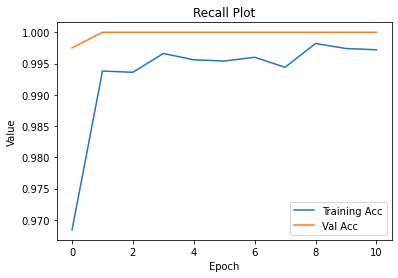

In [105]:
# Visualisasi skor recall Model DenseNet201 selama model training
plt.plot(densenet_history_imp.history['recall_5'], label='Training Acc')
plt.plot(densenet_history_imp.history['val_recall_5'], label='Val Acc')
plt.title('Recall Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

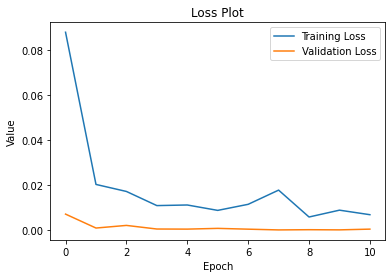

In [103]:
# Visualisasi skor loss Model DenseNet201 selama model training
plt.plot(densenet_history_imp.history['loss'], label='Training Loss')
plt.plot(densenet_history_imp.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [106]:
# Melakukan model evaluasi dengan metric recall
result_train_densenet_imp = model_densenet_imp.evaluate(train_augment, batch_size=256)
result_test_densenet_imp = model_densenet_imp.evaluate(test_dataset, batch_size=256)
print('Train - Loss     : ', result_train_densenet_imp[0])
print('Train - Accuracy : ', result_train_densenet_imp[1])
print('')
print('Test - Loss     : ', result_test_densenet[0])
print('Test - Accuracy : ', result_test_densenet[1])
print('')

4/4 [==============================] - 2s 475ms/step - loss: 0.0109 - recall_5: 0.9961
Train - Loss     :  0.007766664028167725
Train - Accuracy :  0.9994000196456909

Test - Loss     :  0.008011720143258572
Test - Accuracy :  0.9960707426071167



In [109]:
# Melakukan prediksi model terhadap data test
y_pred_test_densenet_imp = (model_densenet_imp.predict(test_dataset) > 0.5)*1

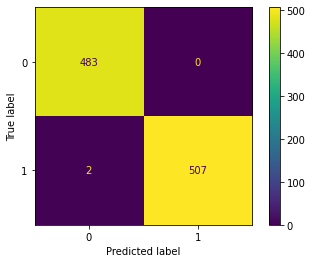

In [110]:
# Membuat confusion matrix berdasarkan prediksi data train
cm = confusion_matrix(y_test_eval, y_pred_test_densenet_imp, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)

disp.plot()
plt.show()

In [111]:
# Membuat classification matrix berdasarkan prediksi data test
print(classification_report(y_test_eval,y_pred_test_densenet_imp))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       483
           1       1.00      1.00      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



In [112]:
test_df['densenet_imp'] = y_pred_test_densenet_imp

In [179]:
# Melakukan query pada kesalahan prediksi model
den_imp_miss = test_df.query('eval != densenet_imp')
den_imp_miss

images        label  eval  \
375  /content/images/Face Mask Dataset/Test/Without...  WithoutMask     1   
963  /content/images/Face Mask Dataset/Test/Without...  WithoutMask     1   

     resnet  densenet  cnn  resnet_imp  densenet_imp  cnn_imp  
375       0         0    1           0             0        1  
963       1         0    1           0             0        1

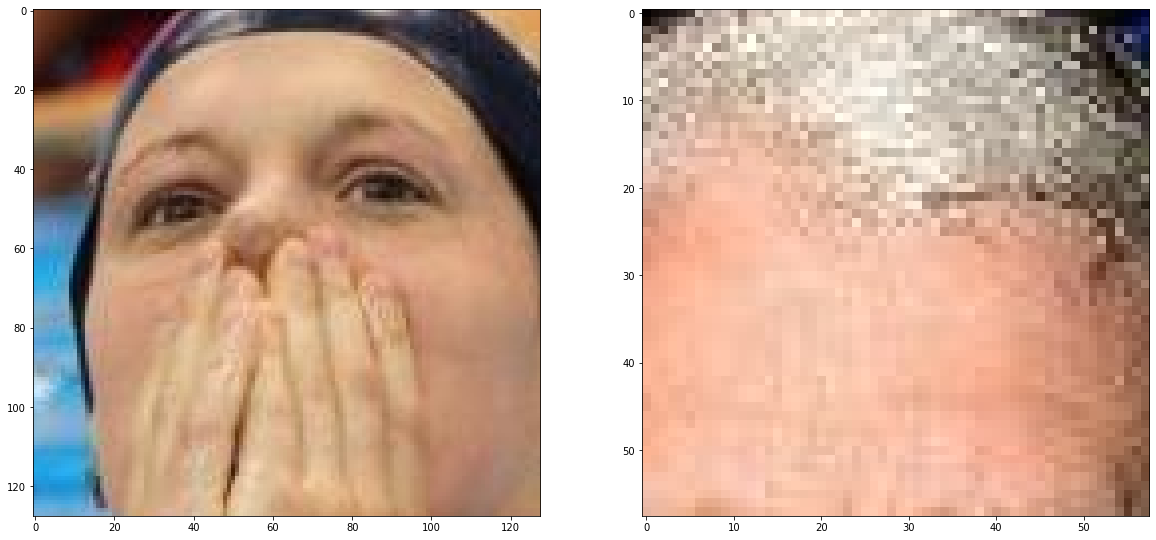

In [180]:
den_imp1 = plt.imread(den_imp_miss.iloc[0,0])
den_imp2 = plt.imread(den_imp_miss.iloc[1,0])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax[0].imshow(den_imp1)
ax[1].imshow(den_imp2)

### 8.6 Model Improvement CNN

In [114]:
model_cnn_imp = Sequential([
    # Menambahkan layer Convolution dengan filter 16
    Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= (150,150,3)),
    MaxPooling2D(pool_size=2, strides=2),
    # Menambahkan layer Convolution dengan filter 32
    Conv2D(filters=32, kernel_size=3, activation= 'relu'),
    MaxPooling2D(pool_size=2, strides=2),
    # Menambahkan layer Convolution dengan filter 64
    Conv2D(filters=64, kernel_size=3, activation= 'relu'),
    MaxPooling2D(pool_size=2, strides=2),
    # Menambahkan layer Flatten untuk mereduksi dimensi input
    Flatten(),
    # Menambahkan hidden layer dengan 128 neuron
    Dense(128, activation='relu'),
    # Menambahkan batch normalization
    BatchNormalization(),
    # Menambahkan hidden layer dengan 64 neuron
    Dense(64, activation='relu'),
    # Menambahkan layer Dropout
    Dropout(rate=0.3),
    #Menambahkan output layer dengan activation sigmoid
    Dense(1, activation='sigmoid')
])

In [115]:
# Mendifinisikan callbacks untuk efisiensi waktu training
callbacks6 = [ 
    EarlyStopping(monitor = 'val_loss', patience = 3), 
    ModelCheckpoint('model_cnn_imp.hdf5', monitor='val_loss', save_best_only=True)]

In [116]:
# Memasukkan hyperparameter pada model
model_cnn_imp.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics = [Recall()])

In [117]:
# Melakukan training dengan 10 kali epochs
cnn_history_imp = model_cnn_imp.fit(train_augment,
                        validation_data=val_dataset,
                        epochs=32,
                        callbacks = callbacks6)

Epoch 1/32
40/40 [==============================] - 59s 1s/step - loss: 0.2151 - recall_6: 0.9464 - val_loss: 0.5469 - val_recall_6: 0.4175
Epoch 2/32
40/40 [==============================] - 59s 1s/step - loss: 0.1236 - recall_6: 0.9648 - val_loss: 0.1427 - val_recall_6: 0.9400
Epoch 3/32
40/40 [==============================] - 59s 1s/step - loss: 0.1015 - recall_6: 0.9712 - val_loss: 0.0913 - val_recall_6: 0.9725
Epoch 4/32
40/40 [==============================] - 65s 2s/step - loss: 0.0920 - recall_6: 0.9738 - val_loss: 0.1481 - val_recall_6: 0.8900
Epoch 5/32
40/40 [==============================] - 73s 2s/step - loss: 0.0836 - recall_6: 0.9762 - val_loss: 0.0567 - val_recall_6: 0.9950
Epoch 6/32
40/40 [==============================] - 57s 1s/step - loss: 0.0710 - recall_6: 0.9798 - val_loss: 0.0875 - val_recall_6: 0.9950
Epoch 7/32
40/40 [==============================] - 59s 1s/step - loss: 0.0680 - recall_6: 0.9756 - val_loss: 0.0362 - val_recall_6: 0.9900
Epoch 8/32
40/40 [==

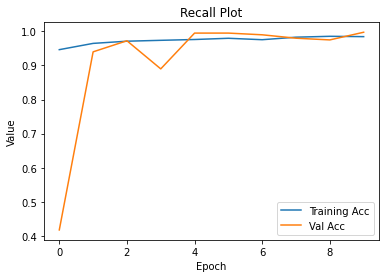

In [118]:
# Visualisasi skor recall pada Model CNN selama model training
plt.plot(cnn_history_imp.history['recall_6'], label='Training Acc')
plt.plot(cnn_history_imp.history['val_recall_6'], label='Val Acc')
plt.title('Recall Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

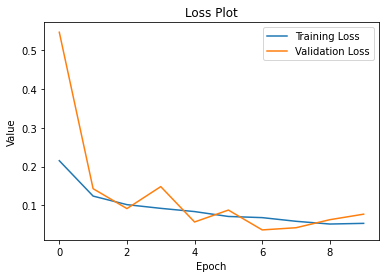

In [119]:
# Visualisasi skor recall pada Model CNN selama model training
plt.plot(cnn_history_imp.history['loss'], label='Training Loss')
plt.plot(cnn_history_imp.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [120]:
# Melakukan evaluasi pada model dengan metric recall
result_train_cnn = model_cnn.evaluate(train_augment, batch_size=256)
result_test_cnn = model_cnn.evaluate(test_dataset, batch_size=256)
print('Train - Loss     : ', result_train_cnn[0])
print('Train - Accuracy : ', result_train_cnn[1])
print('')
print('Test - Loss     : ', result_test_cnn[0])
print('Test - Accuracy : ', result_test_cnn[1])
print('')

4/4 [==============================] - 2s 362ms/step - loss: 0.0330 - recall_2: 0.9921
Train - Loss     :  0.04376407712697983
Train - Accuracy :  0.9944000244140625

Test - Loss     :  0.0330059677362442
Test - Accuracy :  0.9921414256095886



In [121]:
# Melakukan prediksi dengan Model CNN terhadap data test
y_pred_test_cnn_imp = (model_cnn_imp.predict(test_dataset) > 0.5)*1

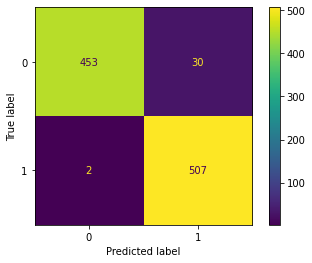

In [122]:
# Membuat confusion matrix berdasarkan prediksi data test
cm = confusion_matrix(y_test_eval, y_pred_test_cnn_imp, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)

disp.plot()
plt.show()

In [123]:
print(classification_report(y_test_eval,y_pred_test_cnn_imp))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       483
           1       0.94      1.00      0.97       509

    accuracy                           0.97       992
   macro avg       0.97      0.97      0.97       992
weighted avg       0.97      0.97      0.97       992



In [124]:
test_df['cnn_imp'] = y_pred_test_cnn_imp

In [169]:
# Melakukan query pada kesalahan prediksi model
cnn_miss = test_df.query('eval != cnn_imp')
cnn_miss

images        label  eval  \
32   /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
66   /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
204  /content/images/Face Mask Dataset/Test/Without...  WithoutMask     1   
209  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
216  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
232  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
249  /content/images/Face Mask Dataset/Test/Without...  WithoutMask     1   
261  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
264  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
281  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
295  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
346  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
363  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
371  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
390  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
411  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
457  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
473  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
532  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
573  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
614  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
674  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
706  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
776  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
787  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
816  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
877  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
887  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
900  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
925  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
934  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   
980  /content/images/Face Mask Dataset/Test/WithMas...     WithMask     0   

     resnet  densenet  cnn  resnet_imp  densenet_imp  cnn_imp  
32        0         0    0           0             0        1  
66        0         0    0           0             0        1  
204       1         1    1           1             1        0  
209       0         0    0           0             0        1  
216       0         0    0           0             0        1  
232       0         0    0           0             0        1  
249       1         1    0           1             1        0  
261       0         0    1           0             0        1  
264       0         0    0           0             0        1  
281       0         0    0           0             0        1  
295       0         0    0           0             0        1  
346       0         0    0           0             0        1  
363       0         0    0           0             0        1  
371       0         0    0           0             0        1  
390       0         0    0           0             0        1  
411       0         0    1           0             0        1  
457       0         1    1           0             0        1  
473       0         0    0           0             0        1  
532       0         0    1           0             0        1  
573       0         0    1           0             0        1  
614       0         0    0           0             0        1  
674       0         0    1           0             0        1  
706       0         0    1        

## Bab 9 Model Inference

### 9.1 Freeze Model

In [129]:
model_resnet.trainable=False
model_densenet.trainable=False
model_cnn.trainable=False
model_resnet_imp.trainable=False
model_densenet_imp.trainable=False
model_cnn_imp.trainable=False

### 9.2 Save Model

In [130]:
model_resnet.save('resnet_model.h5')
model_densenet.save('densenet_model.h5')
model_cnn.save('cnn_model.h5')
model_resnet_imp.save('resnet_imp_model.h5')
model_densenet_imp.save('densenet_imp_model.h5')
model_cnn_imp.save('cnn_imp_model.h5')

In [181]:
model_densenet_imp.save('facemask_model')

In [184]:
! zip -r facemask_model.zip facemask_model

  adding: facemask_model/ (stored 0%)
  adding: facemask_model/assets/ (stored 0%)
  adding: facemask_model/variables/ (stored 0%)
  adding: facemask_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: facemask_model/variables/variables.index (deflated 79%)
  adding: facemask_model/keras_metadata.pb (deflated 97%)
  adding: facemask_model/saved_model.pb (deflated 92%)


### 9.2 Load Model

In [132]:
resnet_model = keras.models.load_model('resnet_model.h5', compile=False)
densenet_model = keras.models.load_model('densenet_model.h5', compile=False)
cnn_model = keras.models.load_model('cnn_model.h5', compile=False)
resnet_imp_model = keras.models.load_model('resnet_imp_model.h5', compile=False)
densenet_imp_model = keras.models.load_model('densenet_imp_model.h5', compile=False)
cnn_imp_model = keras.models.load_model('cnn_imp_model.h5', compile=False)

### 9.3 Inference

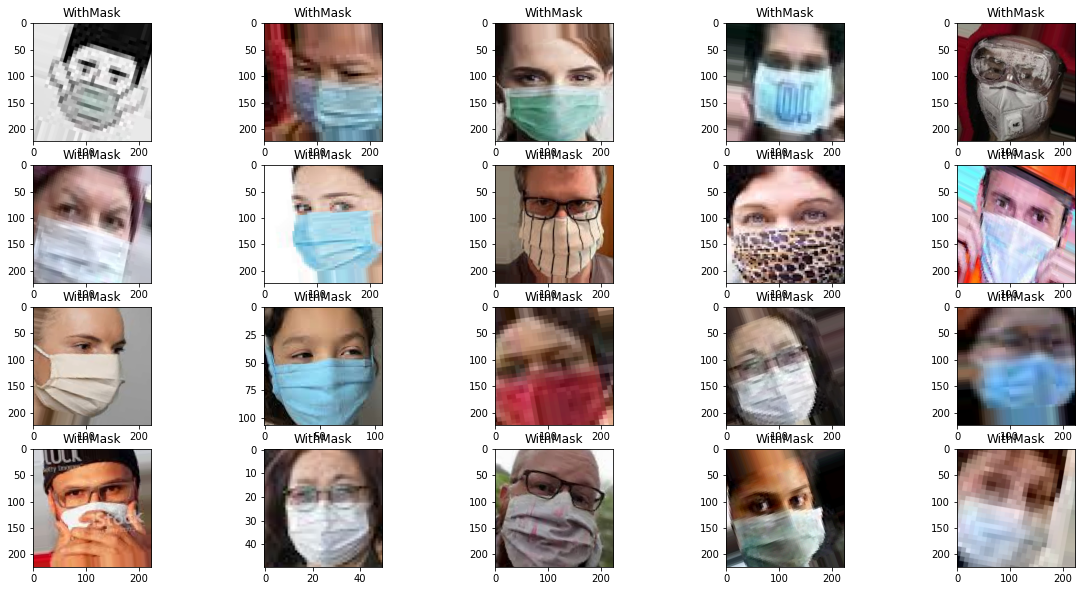

In [145]:
show_inference(inf_withmask_preview)

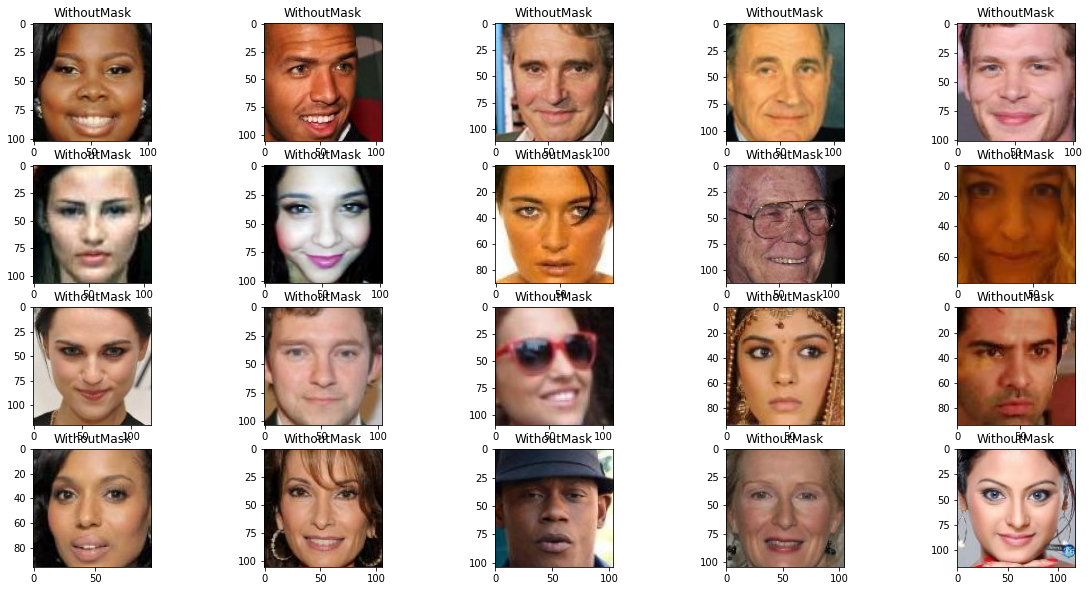

In [146]:
show_inference(inf_withoutmask_preview)

In [126]:
inf_gen_withmask = ImageDataGenerator(rescale=1./255)
inf_gen_withoutmask = ImageDataGenerator(rescale=1./255)

In [128]:
withmask_dataset = inf_gen_withmask .flow_from_dataframe(dataframe=data_inf_withmask,
                                              x_col='images',
                                              y_col='label',
                                              target_size=(img_height, img_width),
                                              batch_size=batch,
                                              shuffle=False,
                                              seed=32)
withoutmask_dataset = inf_gen_withoutmask .flow_from_dataframe(dataframe=data_inf_withoutmask,
                                              x_col='images',
                                              y_col='label',
                                              target_size=(img_height, img_width),
                                              batch_size=batch,
                                              shuffle=False,
                                              seed=32)

Found 20 validated image filenames belonging to 1 classes.
Found 20 validated image filenames belonging to 1 classes.


In [139]:
resnet_pred_withmask = (resnet_model.predict(withmask_dataset) > 0.5)*1 
resnet_pred_withoutmask = (resnet_model.predict(withoutmask_dataset) > 0.5)*1

In [138]:
densenet_pred_withmask = (densenet_model.predict(withmask_dataset) > 0.5)*1 
densenet_pred_withoutmask = (densenet_model.predict(withoutmask_dataset) > 0.5)*1 

In [137]:
cnn_pred_withmask = (cnn_model.predict(withmask_dataset) > 0.5)*1 
cnn_pred_withoutmask = (cnn_model.predict(withoutmask_dataset) > 0.5)*1

In [136]:
resnet_imp_pred_withmask = (resnet_imp_model.predict(withmask_dataset) > 0.5)*1 
resnet_imp_pred_withoutmask = (resnet_imp_model.predict(withoutmask_dataset) > 0.5)*1

In [135]:
densenet_imp_pred_withmask = (densenet_imp_model.predict(withmask_dataset) > 0.5)*1 
densenet_imp_pred_withoutmask = (densenet_imp_model.predict(withoutmask_dataset) > 0.5)*1 

In [134]:
cnn_imp_pred_withmask = (cnn_imp_model.predict(withmask_dataset) > 0.5)*1 
cnn_imp_pred_withoutmask = (cnn_imp_model.predict(withoutmask_dataset) > 0.5)*1

In [140]:
data_inf_withmask['eval'] = data_inf_withmask['label'].map(label_map)
data_inf_withmask['resnet'] = resnet_pred_withmask
data_inf_withmask['densenet'] = densenet_pred_withmask
data_inf_withmask['cnn'] = cnn_pred_withmask
data_inf_withmask['resnet_imp'] = resnet_imp_pred_withmask
data_inf_withmask['densenet_imp'] = densenet_imp_pred_withmask
data_inf_withmask['cnn_imp'] = cnn_imp_pred_withmask
data_inf_withmask

images     label  eval  resnet  \
0   /content/images/Face Mask Dataset/Train/WithMa...  WithMask     0       0   
1   /content/images/Face Mask Dataset/Train/WithMa...  WithMask     0       0   
2   /content/images/Face Mask Dataset/Train/WithMa...  WithMask     0       0   
3   /content/images/Face Mask Dataset/Train/WithMa...  WithMask     0       0   
4   /content/images/Face Mask Dataset/Train/WithMa...  WithMask     0       0   
5   /content/images/Face Mask Dataset/Train/WithMa...  WithMask     0       0   
6   /content/images/Face Mask Dataset/Train/WithMa...  WithMask     0       0   
7   /content/images/Face Mask Dataset/Train/WithMa...  WithMask     0       0   
8   /content/images/Face Mask Dataset/Train/WithMa...  WithMask     0       0   
9   /content/images/Face Mask Dataset/Train/WithMa...  WithMask     0       0   
10  /content/images/Face Mask Dataset/Train/WithMa...  WithMask     0       0   
11  /content/images/Face Mask Dataset/Train/WithMa...  WithMask     0       0   
12  /content/images/Face Mask Dataset/Train/WithMa...  WithMask     0       0   
13  /content/images/Face Mask Dataset/Train/WithMa...  WithMask     0       0   
14  /content/images/Face Mask Dataset/Train/WithMa...  WithMask     0       0   
15  /content/images/Face Mask Dataset/Train/WithMa...  WithMask     0       0   
16  /content/images/Face Mask Dataset/Train/WithMa...  WithMask     0       0   
17  /content/images/Face Mask Dataset/Train/WithMa...  WithMask     0       0   
18  /content/images/Face Mask Dataset/Train/WithMa...  WithMask     0       0   
19  /content/images/Face Mask Dataset/Train/WithMa...  WithMask     0       0   

    densenet  cnn  resnet_imp  densenet_imp  cnn_imp  
0          0    0           0             0        0  
1          0    0           0             0        0  
2          0    0           0             0        0  
3          0    0           0             0        0  
4          0    0           0             0        0  
5          0    0           0             0        0  
6          0    0           0             0        0  
7          0    0           0             0        0  
8          0    0           0             0        0  
9          0    0           0             0        0  
10         0    0           0             0        0  
11         0    0           0             0        0  
12         0    0           0             0        0  
13         0    0           0             0        0  
14         0    0           0             0        0  
15         0    1           0             0        1  
16         0    0           0             0        0  
17         0    0           0             0        0  
18         0    0           0             0        0  
19         0    0           0             0        0

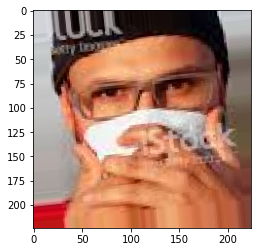

In [143]:
miss_inf_withmask = plt.imread(data_inf_withmask.iloc[15,0])
plt.imshow(miss_inf_withmask )

Kesalahan prediksi ditemukan terdaji pada gambar orang yang menutupi maskernya dengan tangan. 

In [144]:
data_inf_withoutmask['eval'] = data_inf_withoutmask['label'].map(label_map)
data_inf_withoutmask['resnet'] = resnet_pred_withoutmask
data_inf_withoutmask['densenet'] = densenet_pred_withoutmask
data_inf_withoutmask['cnn'] = cnn_pred_withoutmask
data_inf_withoutmask['resnet_imp'] = resnet_imp_pred_withoutmask
data_inf_withoutmask['densenet_imp'] = densenet_imp_pred_withoutmask
data_inf_withoutmask['cnn_imp'] = cnn_imp_pred_withoutmask
data_inf_withoutmask

images        label  eval  \
0   /content/images/Face Mask Dataset/Train/Withou...  WithoutMask     1   
1   /content/images/Face Mask Dataset/Train/Withou...  WithoutMask     1   
2   /content/images/Face Mask Dataset/Train/Withou...  WithoutMask     1   
3   /content/images/Face Mask Dataset/Train/Withou...  WithoutMask     1   
4   /content/images/Face Mask Dataset/Train/Withou...  WithoutMask     1   
5   /content/images/Face Mask Dataset/Train/Withou...  WithoutMask     1   
6   /content/images/Face Mask Dataset/Train/Withou...  WithoutMask     1   
7   /content/images/Face Mask Dataset/Train/Withou...  WithoutMask     1   
8   /content/images/Face Mask Dataset/Train/Withou...  WithoutMask     1   
9   /content/images/Face Mask Dataset/Train/Withou...  WithoutMask     1   
10  /content/images/Face Mask Dataset/Train/Withou...  WithoutMask     1   
11  /content/images/Face Mask Dataset/Train/Withou...  WithoutMask     1   
12  /content/images/Face Mask Dataset/Train/Withou...  WithoutMask     1   
13  /content/images/Face Mask Dataset/Train/Withou...  WithoutMask     1   
14  /content/images/Face Mask Dataset/Train/Withou...  WithoutMask     1   
15  /content/images/Face Mask Dataset/Train/Withou...  WithoutMask     1   
16  /content/images/Face Mask Dataset/Train/Withou...  WithoutMask     1   
17  /content/images/Face Mask Dataset/Train/Withou...  WithoutMask     1   
18  /content/images/Face Mask Dataset/Train/Withou...  WithoutMask     1   
19  /content/images/Face Mask Dataset/Train/Withou...  WithoutMask     1   

    resnet  densenet  cnn  resnet_imp  densenet_imp  cnn_imp  
0        1         1    1           1             1        1  
1        1         1    1           1             1        1  
2        1         1    1           1             1        1  
3        1         1    1           1             1        1  
4        1         1    1           1             1        1  
5        1         1    1           1             1        1  
6        1         1    1           1             1        1  
7        1         1    1           1             1        1  
8        1         1    1           1             1        1  
9        1         1    1           1             1        1  
10       1         1    1           1             1        1  
11       1         1    1           1             1        1  
12       1         1    1           1             1        1  
13       1         1    1           1             1        1  
14       1         1    1           1             1        1  
15       1         1    1           1             1        1  
16       1         1    1           1             1        1  
17       1         1    1           1             1        1  
18       1         1    1           1             1        1  
19       1         1    1           1             1        1

Tidak ditemukan kesalahan pada prediksi kelas WithoutMask pada semua model. Hal ini mungkin terjadi karena semua model memiliki skor recall yang tinggi.

## Bab 10 Kesimpulan

### 10.1 Insight EDA

Pada saat EDA ditemukan bahwa gambar pada dataset untuk kelas WIthMask cenderung memiliki resolusi yang lebih buruk deibanding kelas WithoutMask. Meskipun demikian gambar pada kelas WithoutMask jauh lebih bervariasi jika dilihat dari sudut pengambilan gambar. Selain itu ukuran Gambar pada kelas WithoutMask juga jauh lebih bervariasi dari kelas WithMask. Kelas Withmask hanya terdiri dari gambar manusia saja, tetapi terdapat beberapa gambar ilustrasi kartun dalam kelas WithoutMask. 

Secara proporsi untuk setiap kelas, ditemukan proporsi yang seimbang baik pada data train, test, dan validation. Hal tersebut mungkin yang membantu agar model mempelajadi setiap kelas dengan seimbang sehingga msemua model memiliki performa yang cukup baik.

### 10.2 Model Analysis

Pada penelitian ini dibuat tiga macam model untuk memprediksi penggunaan masker pada dataset gambar. Setelah dilakukan evaluasi dapat terlihat bahwa semua model memiliki performa yang cukup baik. Semua model ditemukan memiliki skor recall yang tinggi yaitu diatas 0.9. Metric recall digunakan pada evaluasi model karena dalam kasus ini peneliti ingin meminimaslisir False Negative model yaitu ketika model mengklasifikasikan gambar orang yang tidak memakai masker mejadi gambar orang memakai masker. Sejalan dengan tujuan penelitian ini yaitu untuk membantu pengawasan peraturan penggunan masker untuk mencegah penyebaran virus, jika terdapat kesalaha seperti itu maka yang terjadi adalah orang yang tidak menggunakan masker tidak akan terdeteksi. Sehingga tujuan pengawasan model gagal dilakukan. Namun ditemukan model memiliki nilai recall yang baik sehinga ditemukan False Negative yang sangat kecil pada prediksi model. Sehingga pada dasarnya ketiga model dapat direkomendasikan untuk digunakan sebagai alat bantu pengawasan pengunjung tempat umum. 

Karena performa model sudah cenderung baik maka melakukan model improvement hanya dengan menggunakan dropout. Droupout digunakan untuk memtikan neuron untuk mencegah model overfit. Peneliti memiliki kekhawatiran bahwa skor recall yang terlalu bagus ketikas training maupun pada saat prediksi dengan data test adalah sebuah kebetulan dan juga bahwa prediksi model tidak dapat digerelaisir pada data yang lain. Sehingga peneliti mencoba mencegah hal tersebut dengan menambahkan prosi dropout pada model dar 0.2 menjadi 0.3. Dari hasil model improvement tersebut. tidak ditemukan perubahan yang signigfikan pada performa ketiga model. Meskipun demikian kesalahan prediksi yang dilakukan model CNN menigkat sementara ditemukan penurunan pada kesalahan prediksi model DenseNet201. Oleh karena itu peneliti akan memilih model Densenet sebagai model terbaik yang akan di deploy.

Meskipun performa model sudah cukup baik tetapi model yang telah dibuat masih memiliki limitasi. Pada setiap model ditemukan kesalahan prediksi pada gambar dengan resolusi yang buruk. Selain itu ketika terdapat gambar orang menutupi mukannya dengan tangan maka model akan mengidentifikasi gambar tersebut sebagai gambar orang memakai masker. Atau gambar orang yang menutupi maskernya dengan tangan akan diprediksi sebagai gambar tanpa masker. Sleain itu orang yang memiliki bulu wajah yang lebat dapat diprediksi oleh model sebagai wajah dengan masker

Saran peneliti untuk pembuatan model selanjutnya adalah membuat model dengan membuat model Image Detection yang bisa memantau pengunjung tempat umum secara realtime.